In [210]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [211]:
!pip install catboost numpy

In [212]:
from catboost import CatBoostRegressor
# bironceki cell kontrol ediyoruz

In [213]:
#gerekli kutuphane
import pandas as pd

#dosya yolu
dosya_yolu = '/content/drive/MyDrive/PYZU_Proje/AmesHousing.csv'

#veriyi oku
df = pd.read_csv(dosya_yolu)

#veriyi göster
df.head()

Order        PID  MS SubClass  ... Sale Type  Sale Condition  SalePrice
0      1  526301100           20  ...       WD           Normal     215000
1      2  526350040           20  ...       WD           Normal     105000
2      3  526351010           20  ...       WD           Normal     172000
3      4  526353030           20  ...       WD           Normal     244000
4      5  527105010           60  ...       WD           Normal     189900

[5 rows x 82 columns]

In [214]:
# Satır ve sütun sayısını göster
print(f"📐 Veri seti boyutu: {df.shape[0]} satır, {df.shape[1]} sütun\n")

# Sütun isimleri, veri tipleri ve eksik değer sayısı ( \n bir sonraki satıra geçmek için kullanılır)
print("📊 Sütun bilgileri ve veri tipleri:\n")
print(df.info())

# İlk 5 satırı örnek olarak göster (df.head(buraya bir sayı da yazabilirsiniz))
print("\n🔍 İlk 5 satır:")
print(df.head())

📐 Veri seti boyutu: 2930 satır, 82 sütun

📊 Sütun bilgileri ve veri tipleri:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-nu

In [215]:
import os

# Gereksiz sütunları tanımla
gereksiz_sutunlar = [
    'Order', 'PID', 'Street', 'Alley', 'Utilities', 'Land Slope',
    'Condition 2', 'Roof Matl', 'BsmtFin SF 2', 'Heating',
    'Low Qual Fin SF', 'Bsmt Half Bath', 'Kitchen AbvGr',
    'Garage Cond', '3Ssn Porch', 'Pool Area', 'Pool QC',
    'Fence', 'Misc Feature', 'Misc Val'
]

# Bu sütunları df üzerinden çıkar
# errors='ignore' parametresi ile listedeki olmayan sütunlar hata vermeden atlanır.
df = df.drop(columns=gereksiz_sutunlar, errors='ignore')

# Yeni CSV dosyasını kaydet
csv_kayit_yolu = '/content/drive/MyDrive/VeriBilimiH05/AmesHousing_ClearColumns.csv'

# Dizini oluştur (eğer yoksa)
directory = os.path.dirname(csv_kayit_yolu)
if not os.path.exists(directory):
    os.makedirs(directory)

df.to_csv(csv_kayit_yolu, index=False)

# Bilgilendirme
print(f"✅ Gereksiz sütunlar çıkarıldı: {gereksiz_sutunlar}")
print(f"💾 Yeni veri dosyası kaydedildi: {csv_kayit_yolu}")
print(f"📐 Yeni veri seti boyutu: {df.shape[0]} satır, {df.shape[1]} sütun")

✅ Gereksiz sütunlar çıkarıldı: ['Order', 'PID', 'Street', 'Alley', 'Utilities', 'Land Slope', 'Condition 2', 'Roof Matl', 'BsmtFin SF 2', 'Heating', 'Low Qual Fin SF', 'Bsmt Half Bath', 'Kitchen AbvGr', 'Garage Cond', '3Ssn Porch', 'Pool Area', 'Pool QC', 'Fence', 'Misc Feature', 'Misc Val']
💾 Yeni veri dosyası kaydedildi: /content/drive/MyDrive/VeriBilimiH05/AmesHousing_ClearColumns.csv
📐 Yeni veri seti boyutu: 2930 satır, 62 sütun


In [216]:
# Eksik verileri işlemek için fonksiyon
def eksik_veri_isle(df, threshold=20):
    """
    Eksik verileri işleyen fonksiyon (Pandas 3.0 uyumlu).

    Parametreler:
    df (pd.DataFrame): Giriş veri seti
    threshold (float): Eksik veri oranı eşik değeri (% olarak)

    Dönüş:
    pd.DataFrame: Eksik verileri temizlenmiş yeni DataFrame
    """
    df_copy = df.copy()

    # Eksik veri oranlarını hesapla
    missing_ratio = (df_copy.isnull().sum() / len(df_copy)) * 100

    # Threshold üzerindeki sütunları çıkar
    drop_cols = missing_ratio[missing_ratio >= threshold].index.tolist()
    df_copy = df_copy.drop(columns=drop_cols)

    # Geriye kalan eksik verileri doldur
    for col in df_copy.columns:
        if df_copy[col].isnull().sum() > 0:
            if df_copy[col].dtype in ['float64', 'int64']:
                # Sayısal veri: medyan ile doldur
                median_value = df_copy[col].median()
                df_copy[col] = df_copy[col].fillna(median_value)
            else:
                # Kategorik veri: en sık (mod) ile doldur
                mode_value = df_copy[col].mode()[0]
                df_copy[col] = df_copy[col].fillna(mode_value)

    return df_copy


In [217]:
# Örnek kullanım 1: Tüm eksik veriler doldurulsun (hiçbir sütun atılmadan)
df_doldu_0 = eksik_veri_isle(df, threshold=30)

import os
output_dir = '/content/drive/MyDrive/VeriBilimiH05'
os.makedirs(output_dir, exist_ok=True) # Dizini oluştur, zaten varsa hata verme

df_doldu_0.to_csv(os.path.join(output_dir, 'AmesHousing_filled_all.csv'), index=False)

# Örnek kullanım 2: %20 ve üzeri eksik sütunlar atılsın, kalanlar doldurulsun
df_doldu_20 = eksik_veri_isle(df, threshold=20)
df_doldu_20.to_csv(os.path.join(output_dir, 'AmesHousing_filled_thresh20.csv'), index=False)


In [218]:
# Sayısal öznitelikler için istatistiksel özet
print("📊 Sayısal Sütunların İstatistiksel Özeti:\n")
print(df.describe().T)

# Kategorik öznitelikleri seç
kategorik_sutunlar = df.select_dtypes(include=['object']).columns.tolist()

print("\n🧩 Kategorik Sütunların Temel Bilgisi:\n")
for col in kategorik_sutunlar:
    print(f"--- {col} ---")
    print(f"Benzersiz Değer Sayısı: {df[col].nunique()}")
    print(f"En Sık Değer: {df[col].mode()[0]}")
    print(f"Frekansı: {df[col].value_counts().iloc[0]}") # .iloc (integer location) fonksiyonu, Pandas’ta satır ve sütunları indeks (pozisyon) bazlı seçmek için kullanılır.
    print()


📊 Sayısal Sütunların İstatistiksel Özeti:

                 count           mean  ...        75%       max
MS SubClass     2930.0      57.387372  ...      70.00     190.0
Lot Frontage    2440.0      69.224590  ...      80.00     313.0
Lot Area        2930.0   10147.921843  ...   11555.25  215245.0
Overall Qual    2930.0       6.094881  ...       7.00      10.0
Overall Cond    2930.0       5.563140  ...       6.00       9.0
Year Built      2930.0    1971.356314  ...    2001.00    2010.0
Year Remod/Add  2930.0    1984.266553  ...    2004.00    2010.0
Mas Vnr Area    2907.0     101.896801  ...     164.00    1600.0
BsmtFin SF 1    2929.0     442.629566  ...     734.00    5644.0
Bsmt Unf SF     2929.0     559.262547  ...     802.00    2336.0
Total Bsmt SF   2929.0    1051.614544  ...    1302.00    6110.0
1st Flr SF      2930.0    1159.557679  ...    1384.00    5095.0
2nd Flr SF      2930.0     335.455973  ...     703.75    2065.0
Gr Liv Area     2930.0    1499.690444  ...    1742.75    5642

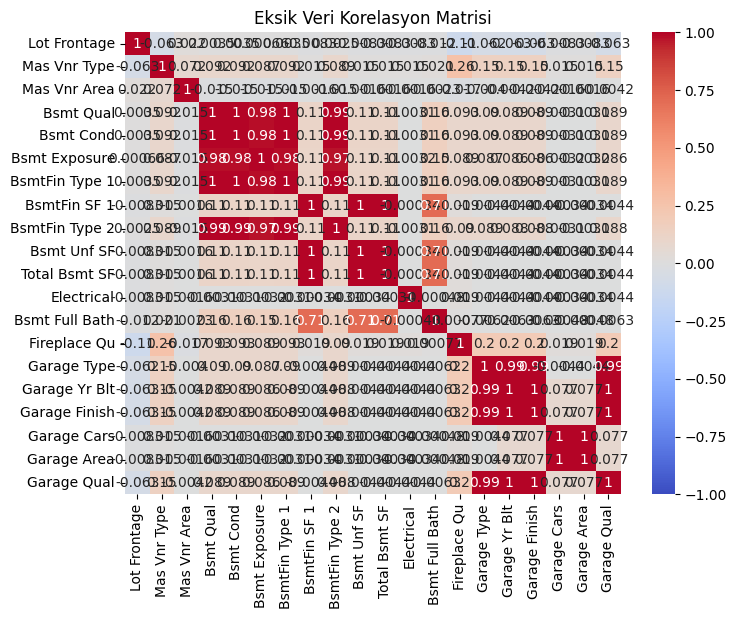

In [219]:
import seaborn as sns
import matplotlib.pyplot as plt

# Eksik veri matrisini oluştur (True/False → 1/0)
missing_mask = df.isnull()

# Sadece eksik verisi olan sütunlar
missing_only = missing_mask.loc[:, missing_mask.any()]

# Korelasyon matrisini hesapla
missing_corr = missing_only.corr()

# Görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(missing_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Eksik Veri Korelasyon Matrisi')
plt.show()


In [220]:
# Sayısal sütunları al (numerical_cols matrisi oluşturalım ve bunu daha sonra grafik çizdirmek için kullanalım)
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

print("🔢 Sayısal değişkenler:")
print(numerical_cols)


🔢 Sayısal değişkenler:
['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', 'Screen Porch', 'Mo Sold', 'Yr Sold', 'SalePrice']


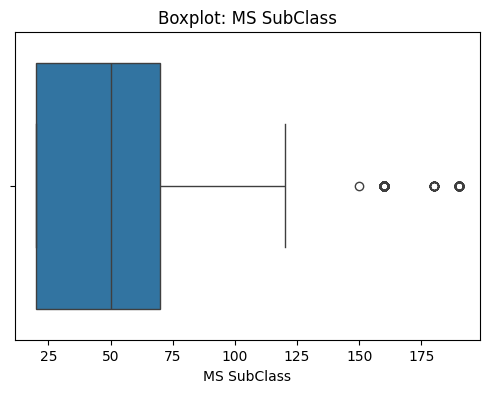

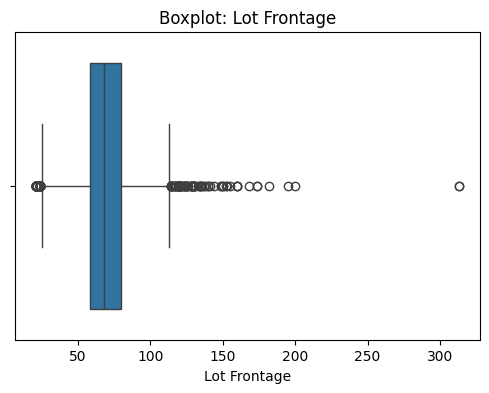

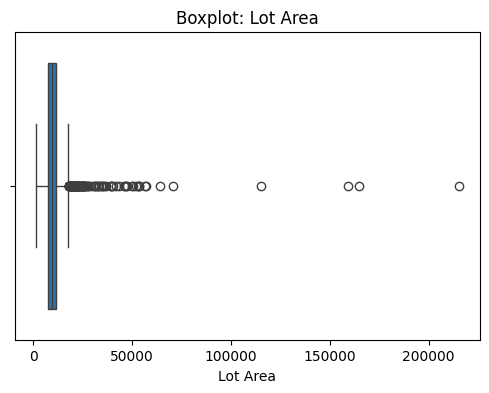

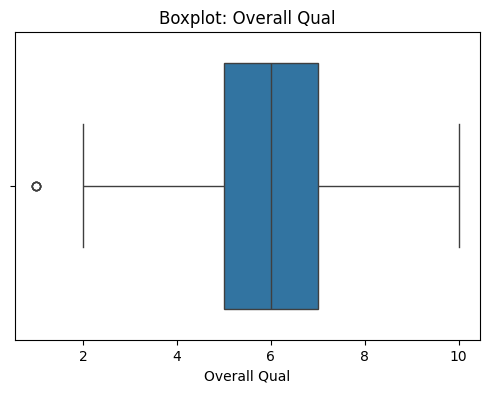

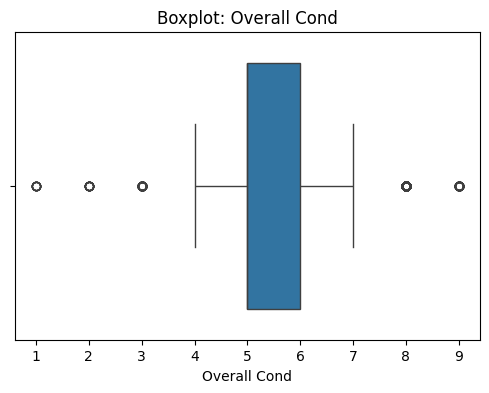

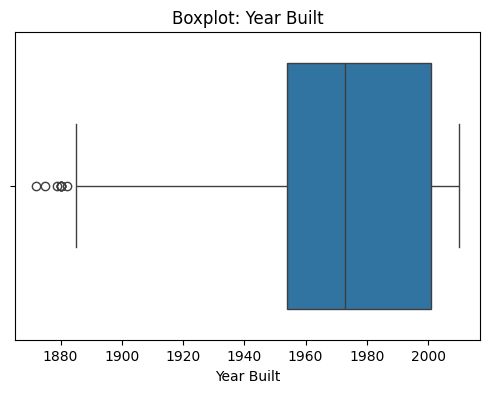

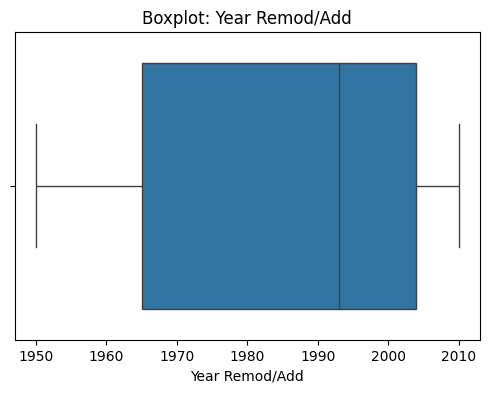

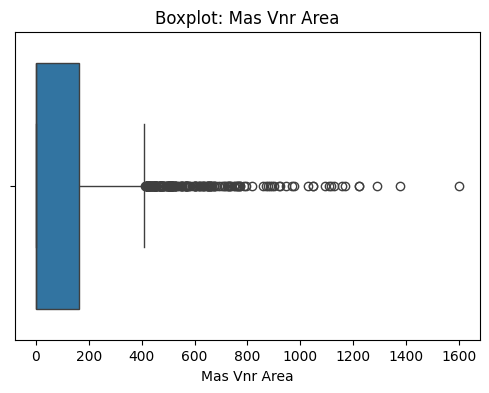

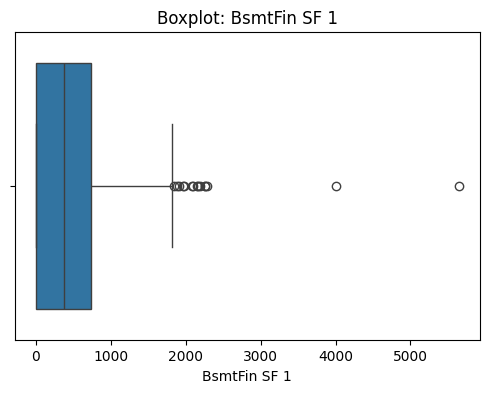

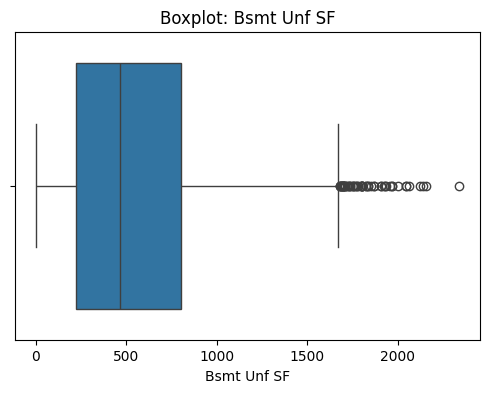

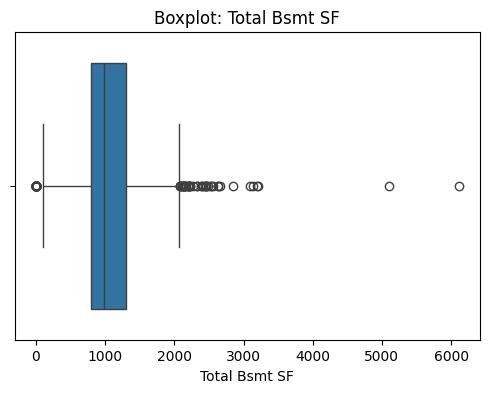

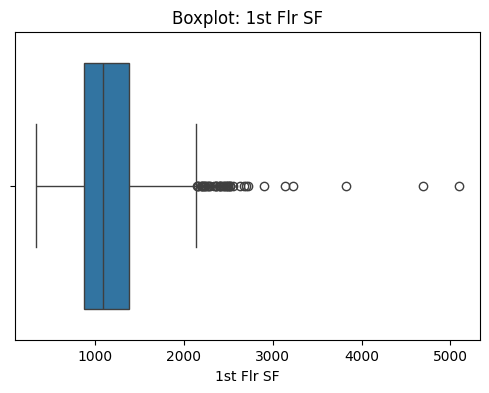

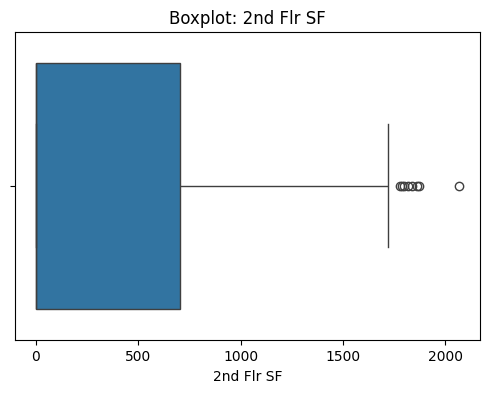

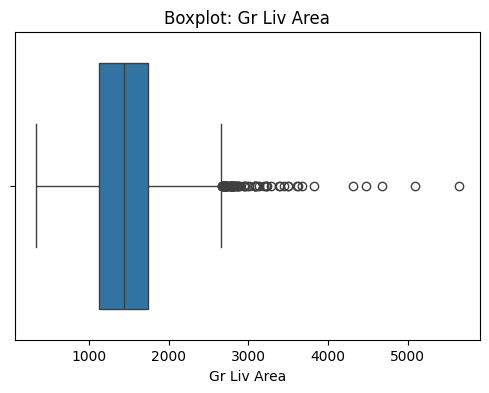

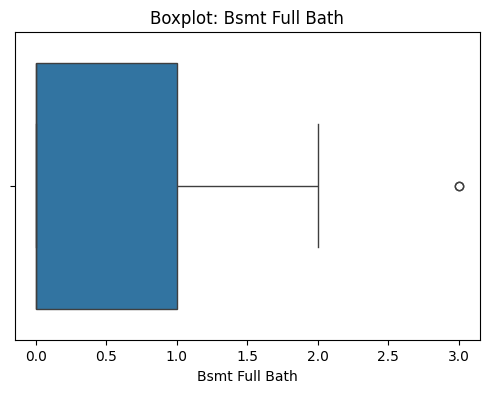

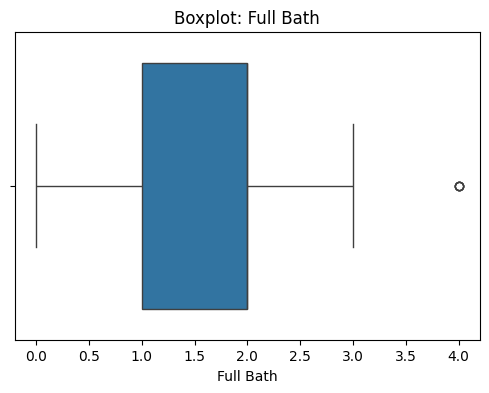

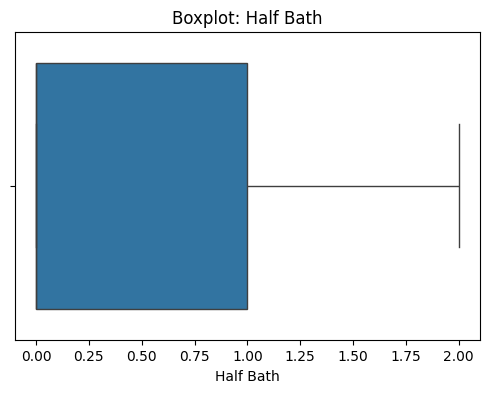

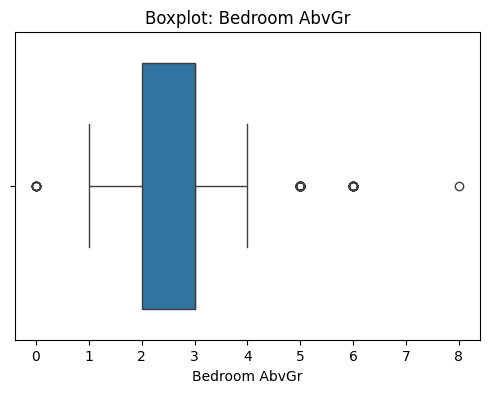

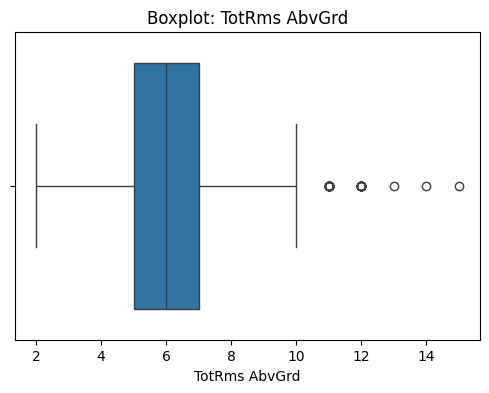

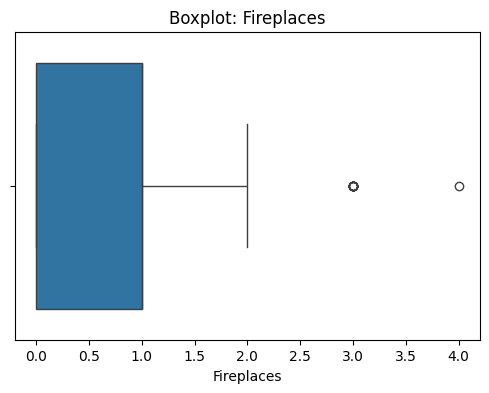

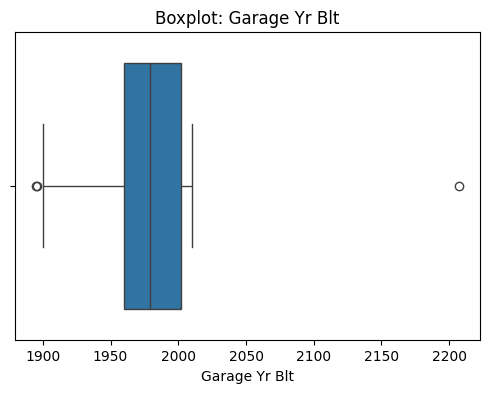

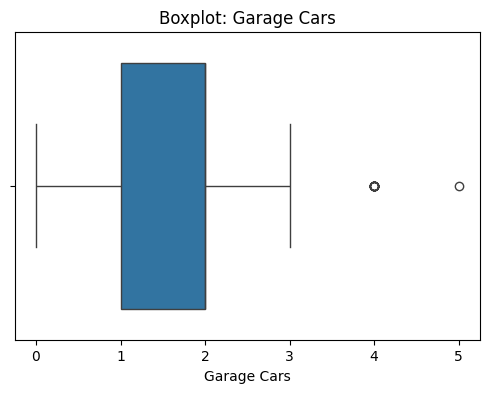

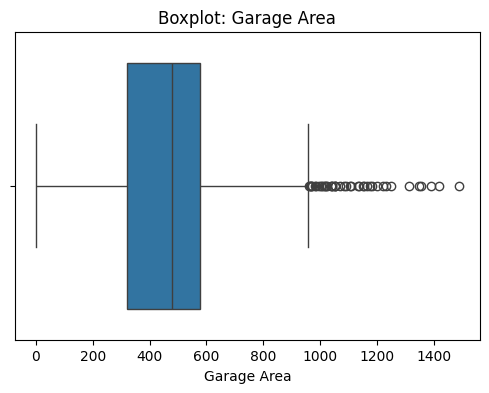

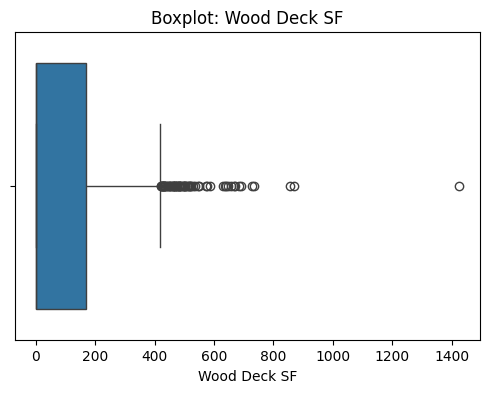

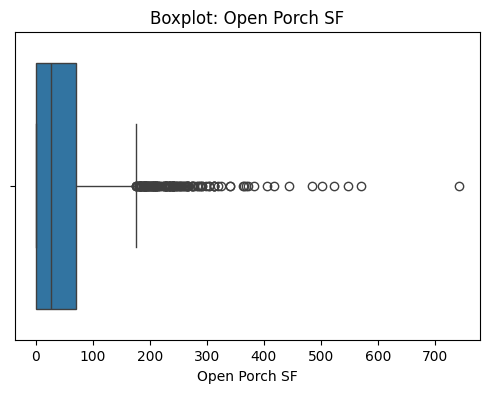

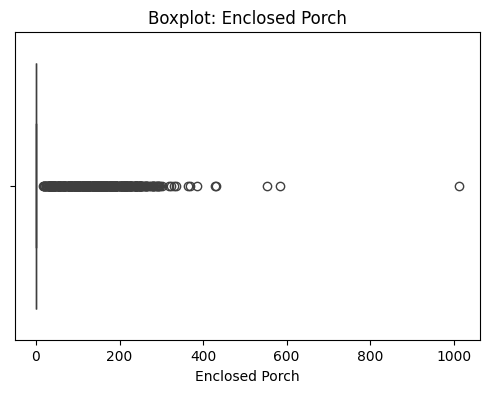

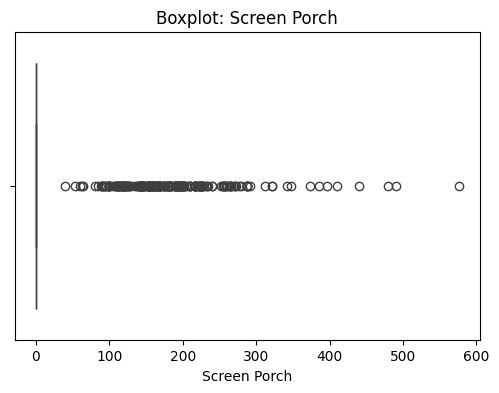

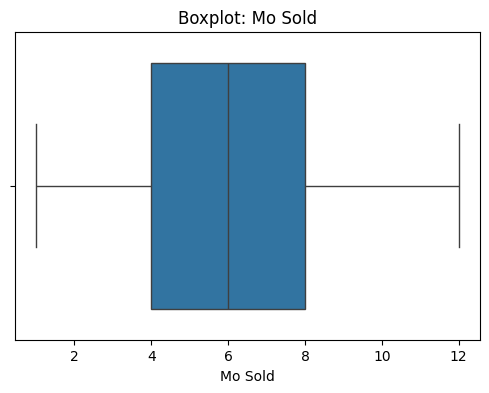

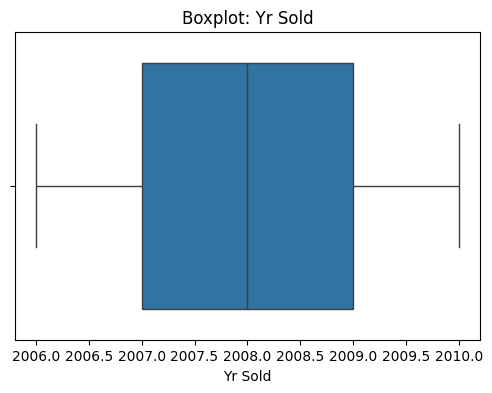

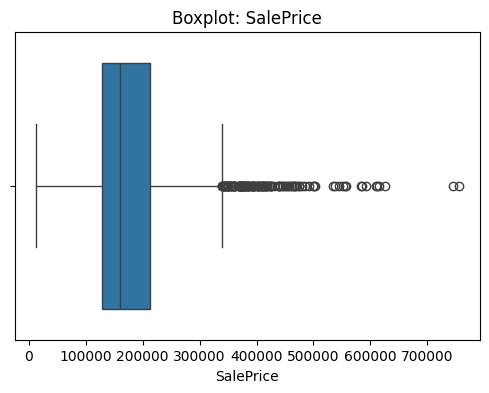

In [221]:
import seaborn as sns
import matplotlib.pyplot as plt

# Her sayısal değişken için boxplot çiz
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot: {col}')
    plt.show()


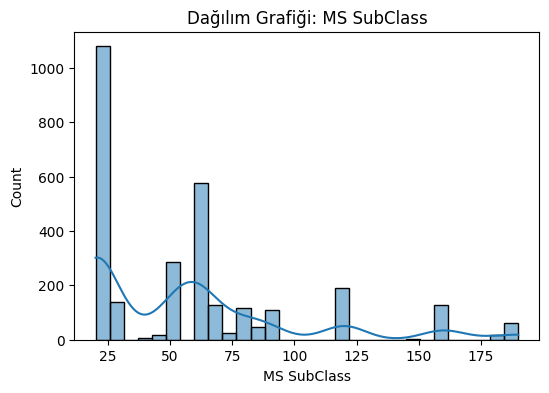

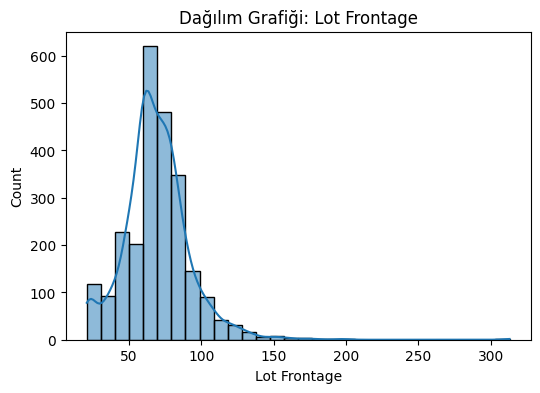

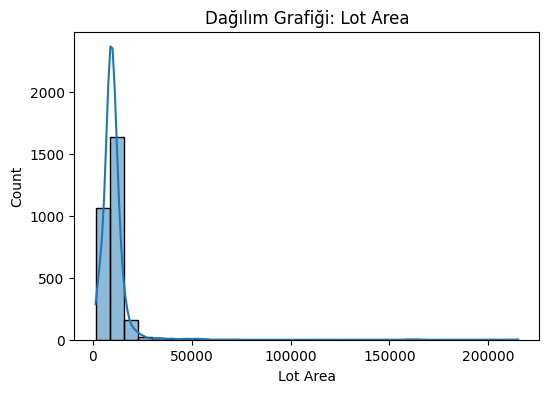

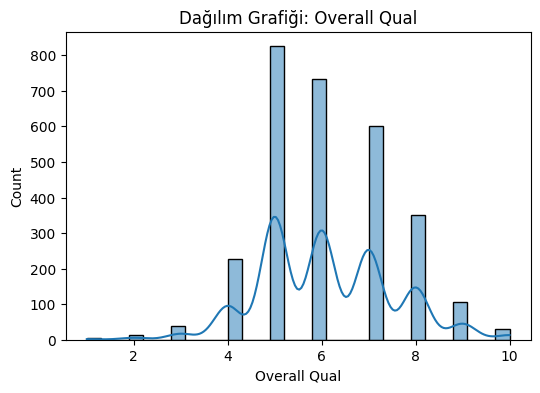

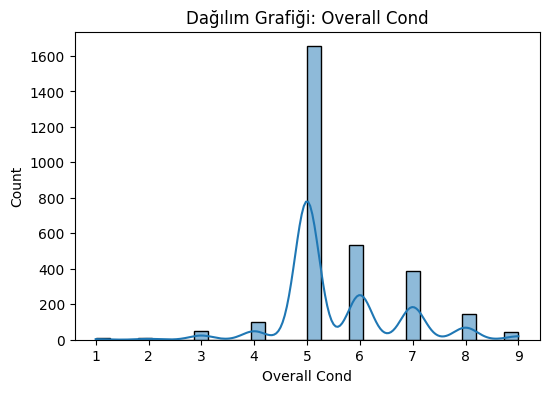

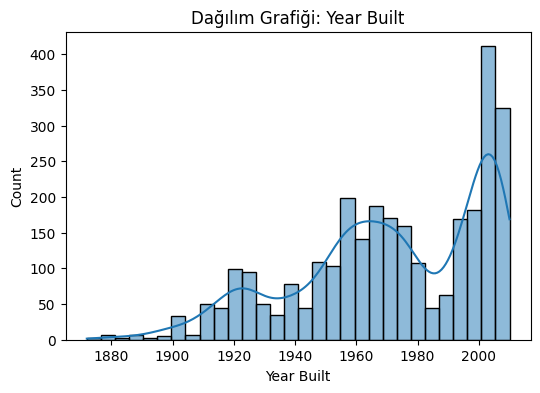

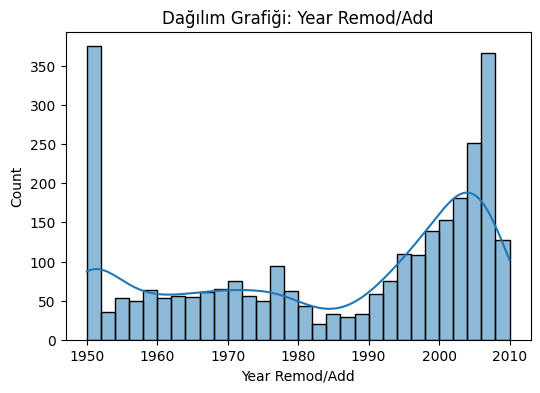

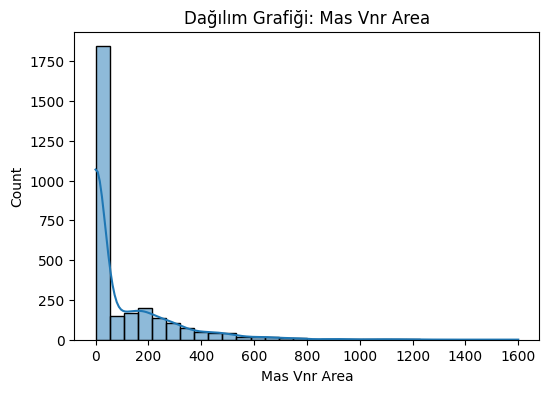

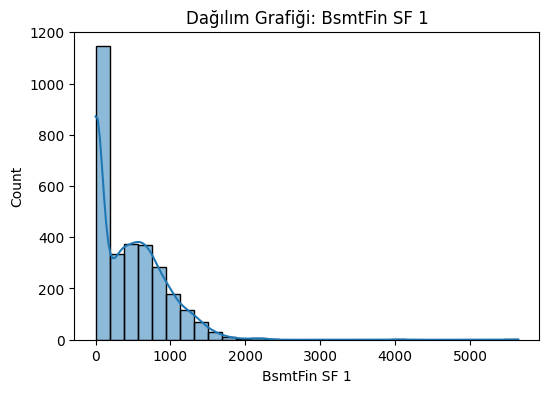

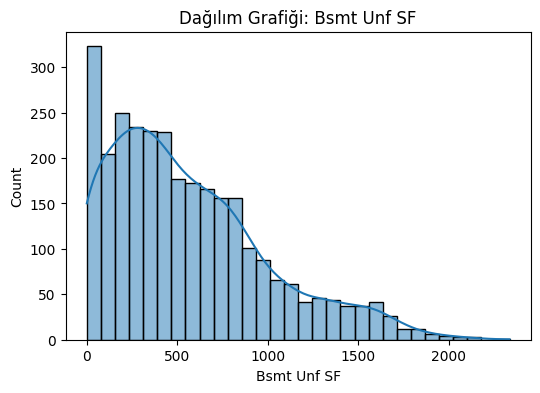

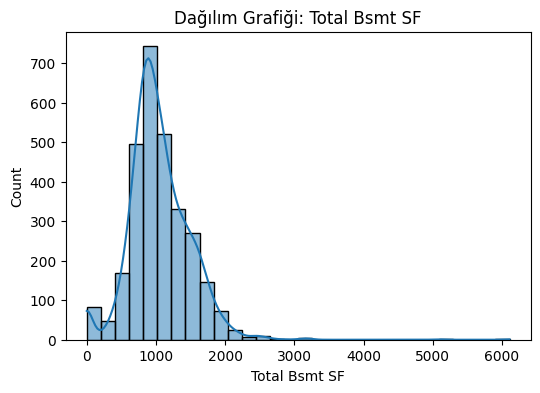

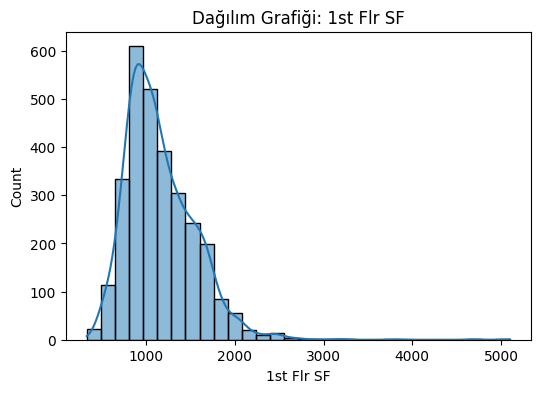

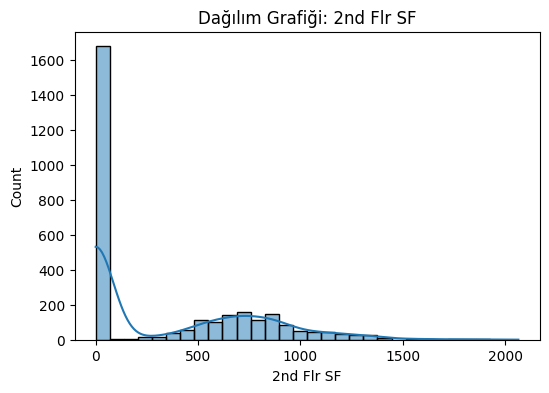

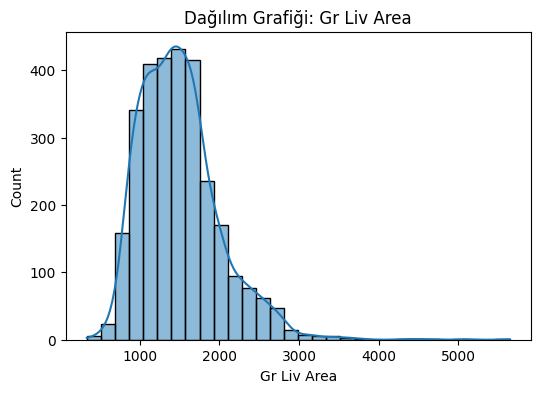

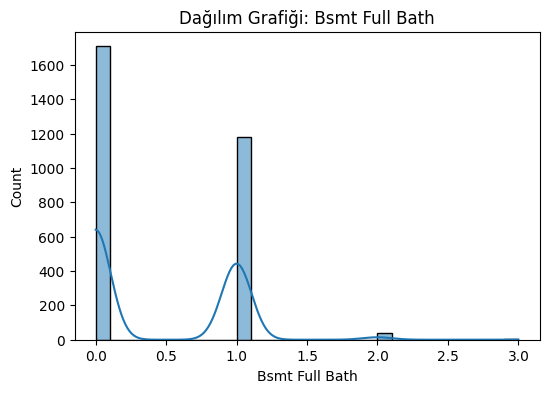

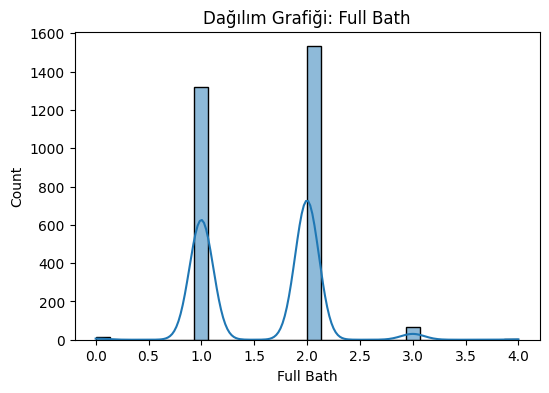

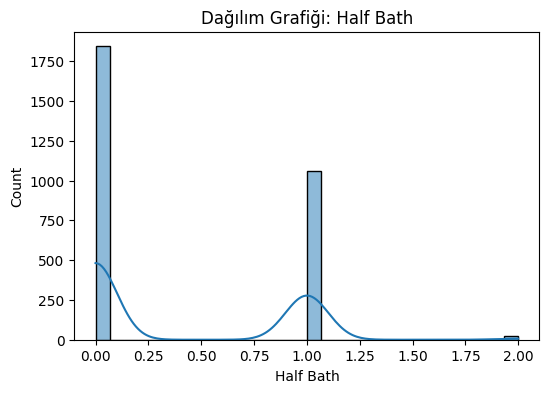

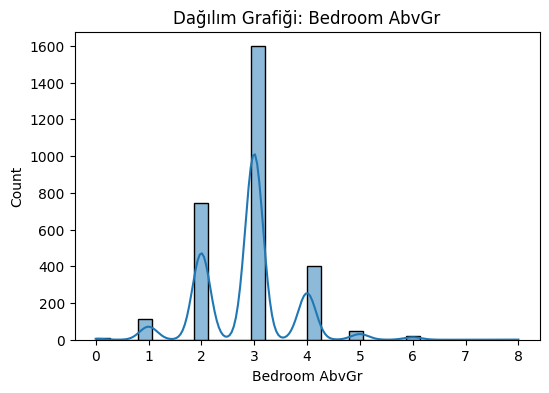

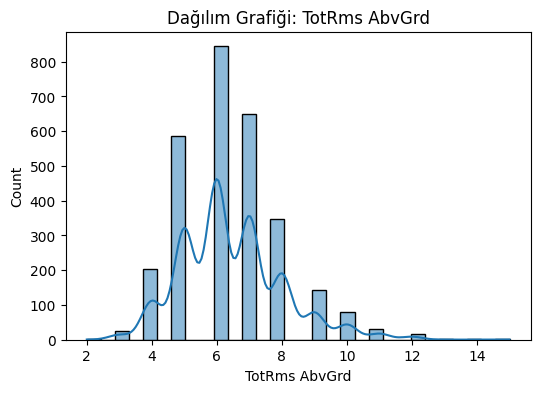

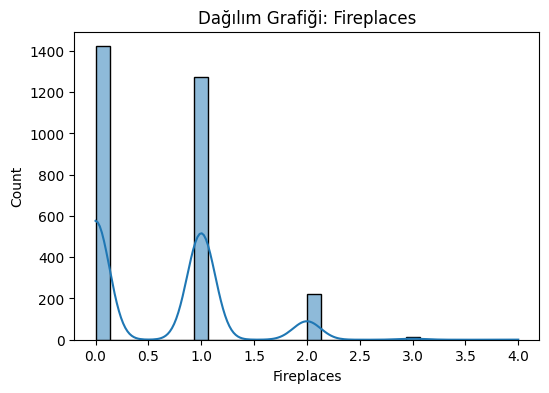

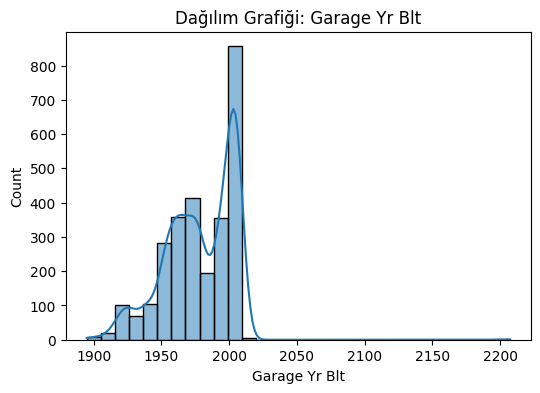

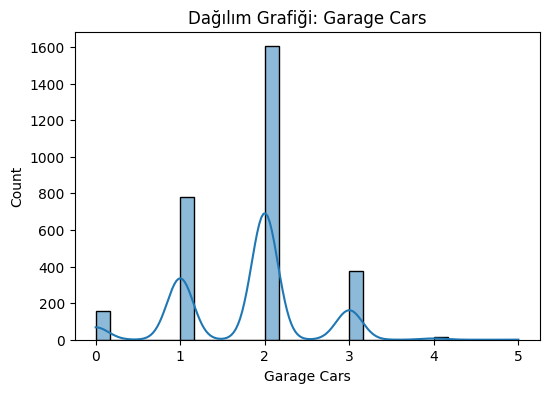

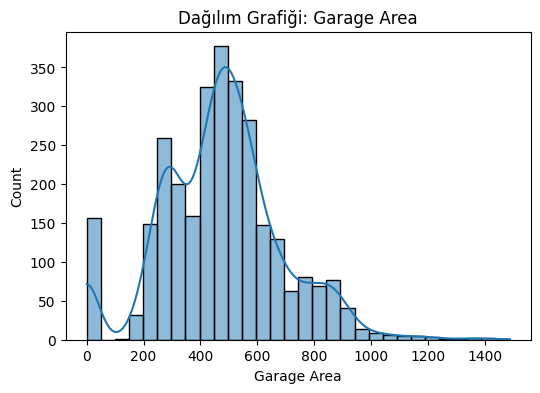

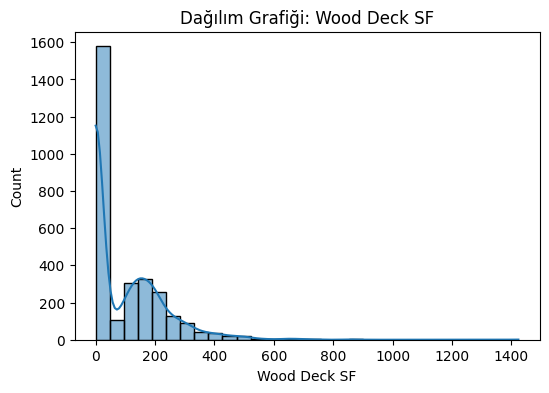

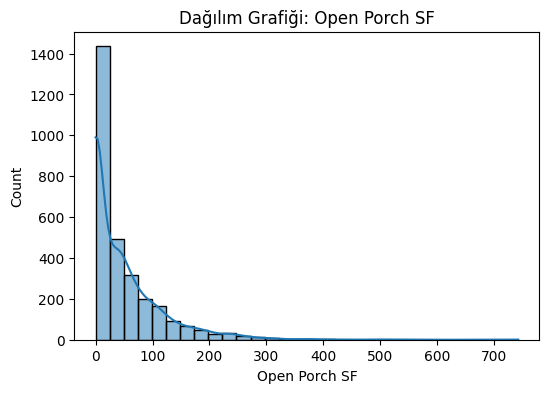

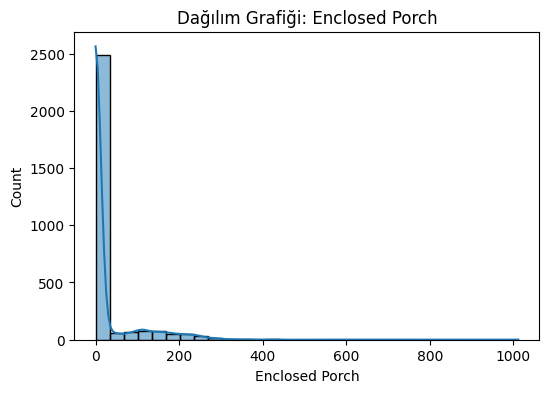

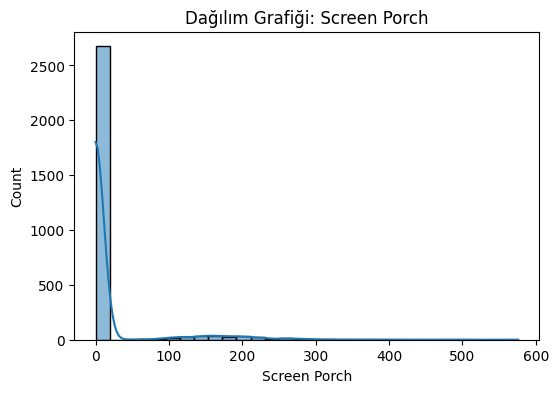

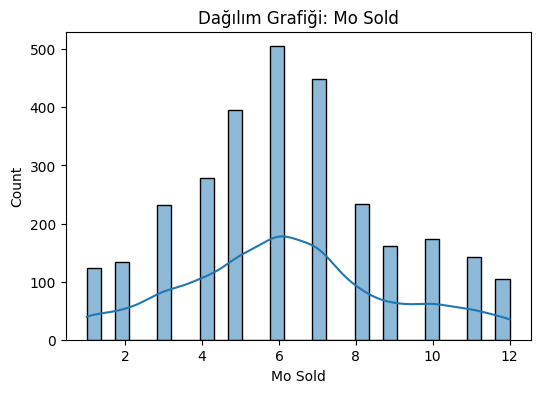

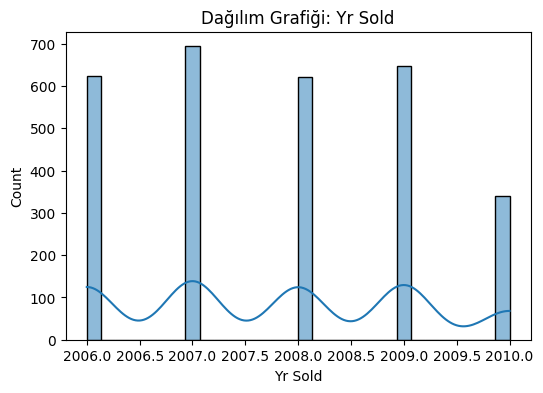

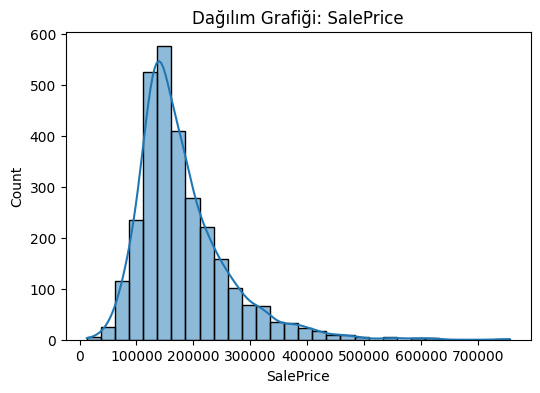

In [222]:
# Her sayısal değişken için histogram (distribution plot), verilerin dağılımlarını görmek için kullanıyoruz, bu dağılımlara göre IQR ile aykırı değerleri atabiliriz
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30) # KDE (Kernel Density Estimation): KDE grafiği, bir veri kümesinin olasılık yoğunluk fonksiyonunu pürüzsüz (smooth) bir şekilde tahmin etmek için kullanılır.
    plt.title(f'Dağılım Grafiği: {col}')
    plt.show()


In [223]:
# Aykırı değerleri tutan sözlük (iqr_bounds)
iqr_bounds = {}

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    alt_sinir = Q1 - 1.5 * IQR
    ust_sinir = Q3 + 1.5 * IQR
    iqr_bounds[col] = (alt_sinir, ust_sinir)

    aykiri_sayisi = df[(df[col] < alt_sinir) | (df[col] > ust_sinir)].shape[0]
    print(f"🚩 {col}: {aykiri_sayisi} aykırı değer tespit edildi.")


🚩 MS SubClass: 208 aykırı değer tespit edildi.
🚩 Lot Frontage: 187 aykırı değer tespit edildi.
🚩 Lot Area: 127 aykırı değer tespit edildi.
🚩 Overall Qual: 4 aykırı değer tespit edildi.
🚩 Overall Cond: 252 aykırı değer tespit edildi.
🚩 Year Built: 9 aykırı değer tespit edildi.
🚩 Year Remod/Add: 0 aykırı değer tespit edildi.
🚩 Mas Vnr Area: 200 aykırı değer tespit edildi.
🚩 BsmtFin SF 1: 15 aykırı değer tespit edildi.
🚩 Bsmt Unf SF: 56 aykırı değer tespit edildi.
🚩 Total Bsmt SF: 123 aykırı değer tespit edildi.
🚩 1st Flr SF: 43 aykırı değer tespit edildi.
🚩 2nd Flr SF: 8 aykırı değer tespit edildi.
🚩 Gr Liv Area: 75 aykırı değer tespit edildi.
🚩 Bsmt Full Bath: 2 aykırı değer tespit edildi.
🚩 Full Bath: 4 aykırı değer tespit edildi.
🚩 Half Bath: 0 aykırı değer tespit edildi.
🚩 Bedroom AbvGr: 78 aykırı değer tespit edildi.
🚩 TotRms AbvGrd: 51 aykırı değer tespit edildi.
🚩 Fireplaces: 13 aykırı değer tespit edildi.
🚩 Garage Yr Blt: 3 aykırı değer tespit edildi.
🚩 Garage Cars: 17 aykırı değ

In [224]:
from copy import deepcopy

# Yeni veri çerçevesi oluştur
df_winsorized = deepcopy(df)

# Winsorization işlemi (her sayısal değişken için)
for col in numerical_cols:
    alt, ust = iqr_bounds[col]
    df_winsorized[col] = df_winsorized[col].clip(lower=alt, upper=ust)

print("\n✅ Aykırı değerler winsorization yöntemiyle sınır değerlerde kesildi.")



✅ Aykırı değerler winsorization yöntemiyle sınır değerlerde kesildi.


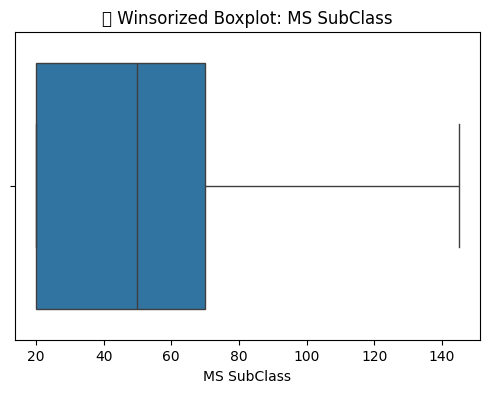

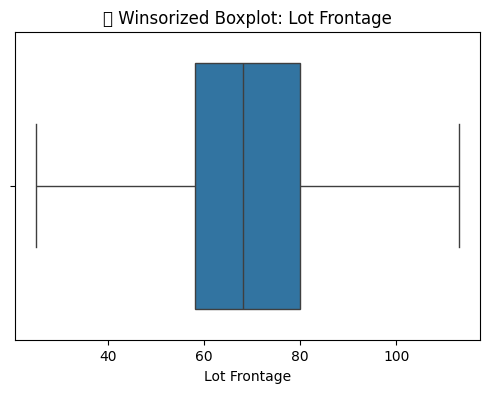

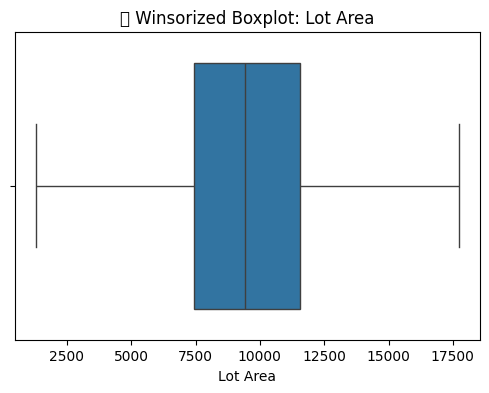

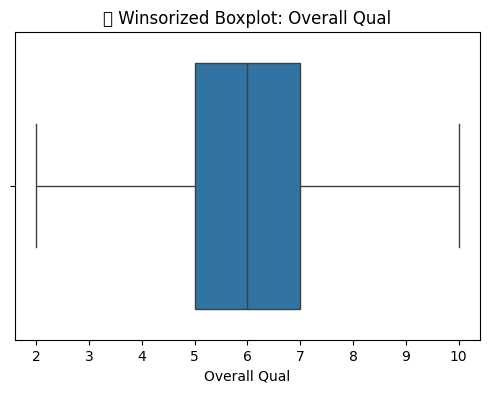

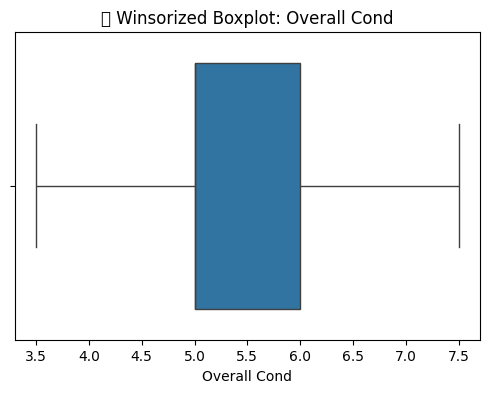

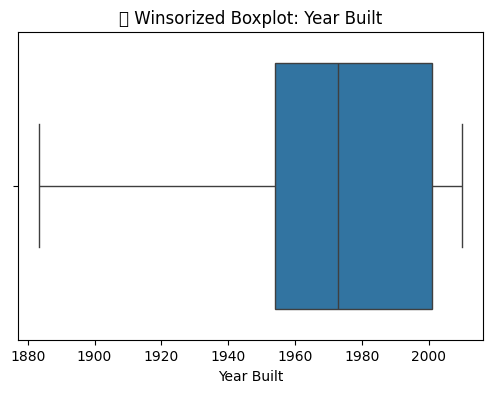

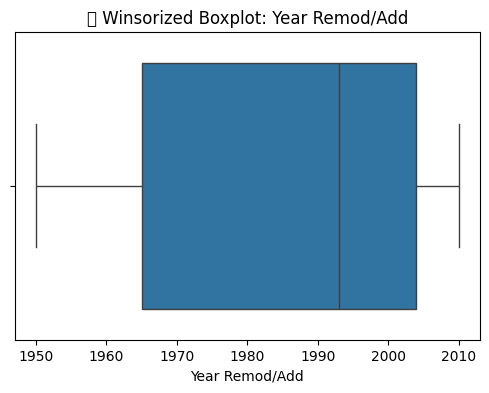

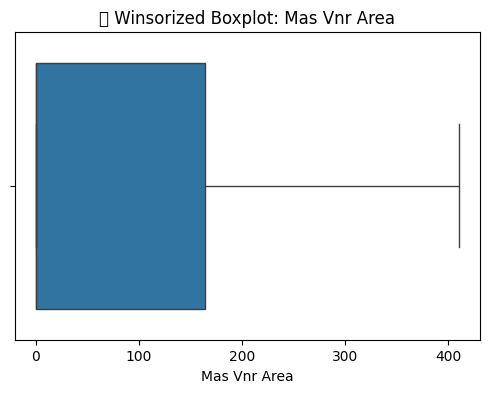

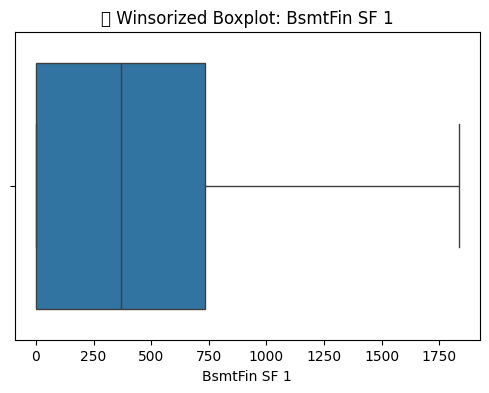

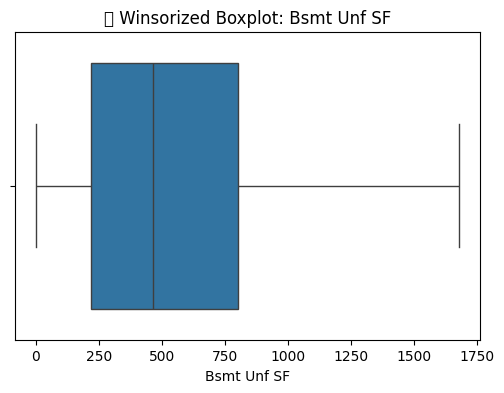

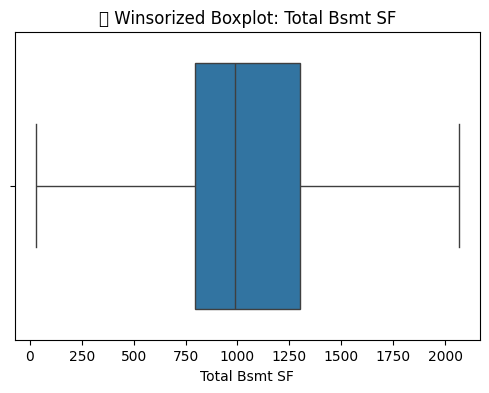

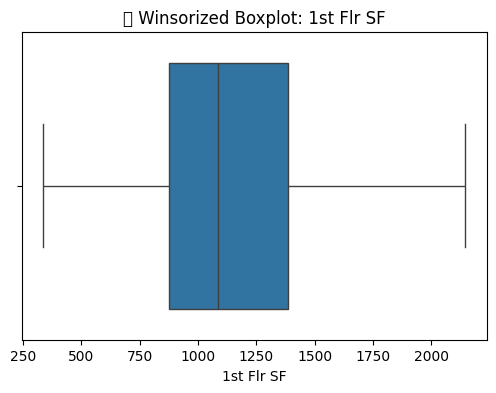

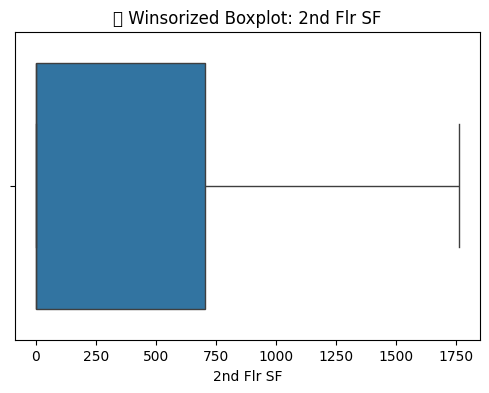

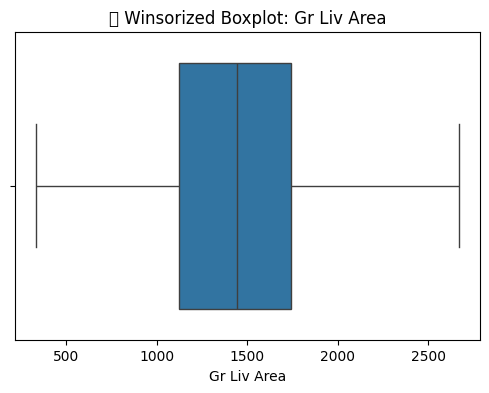

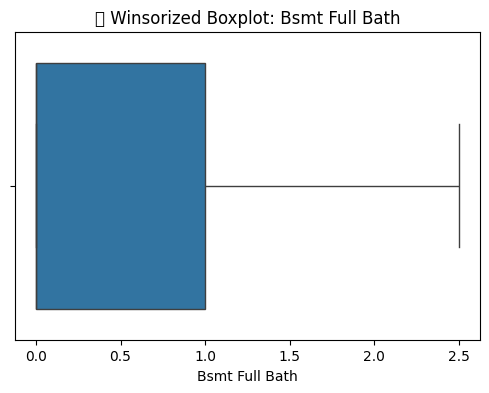

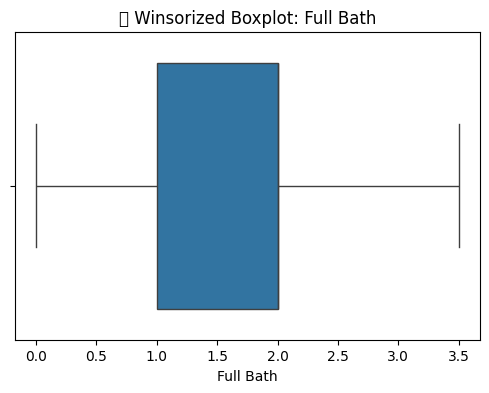

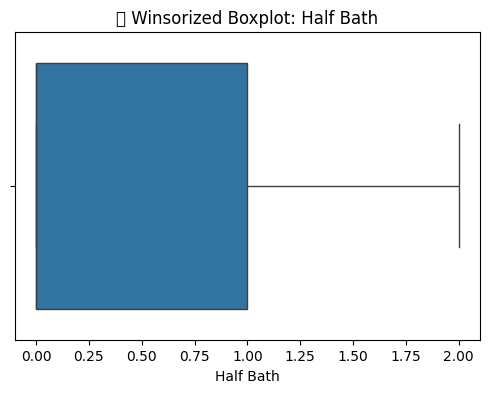

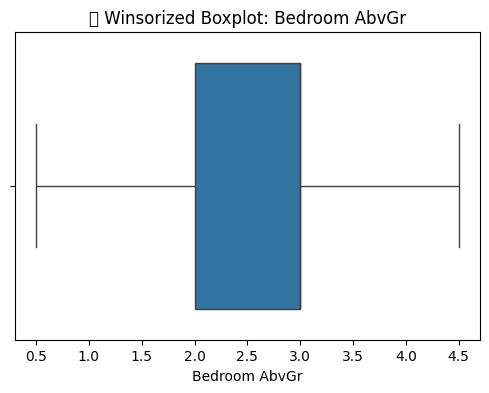

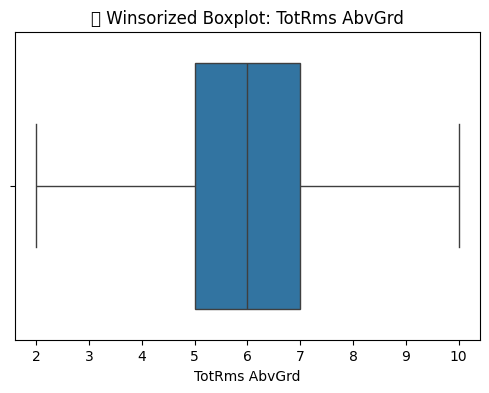

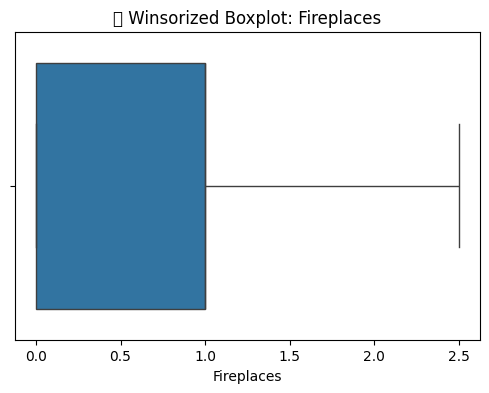

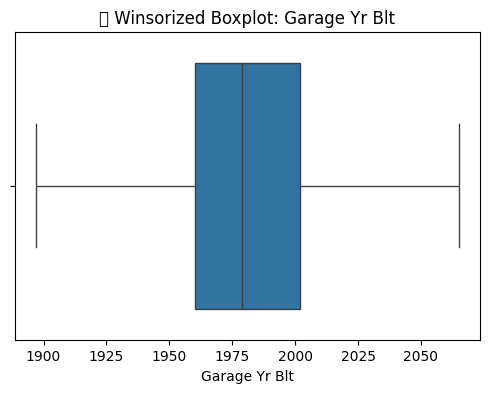

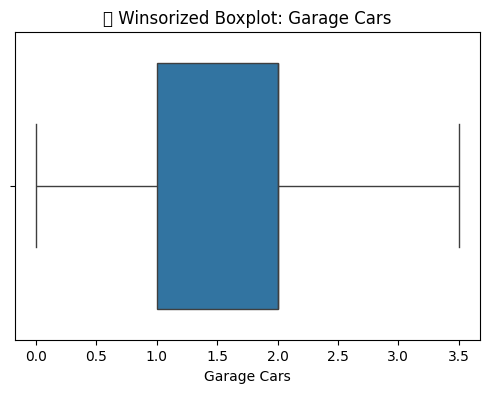

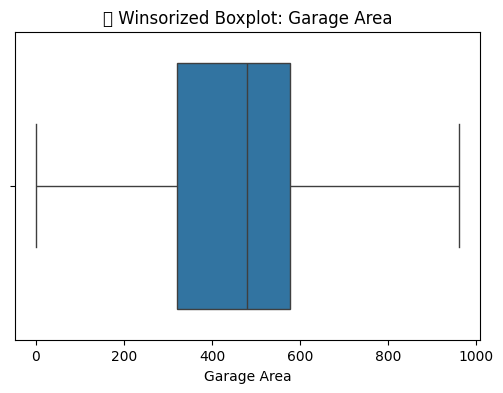

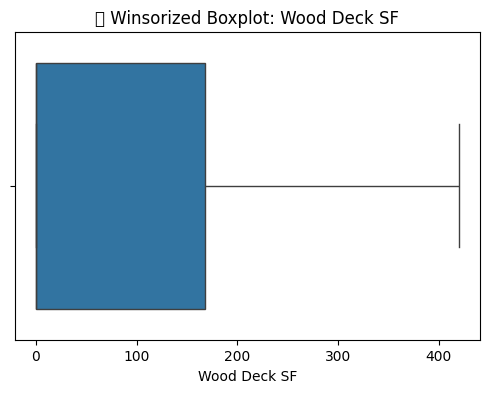

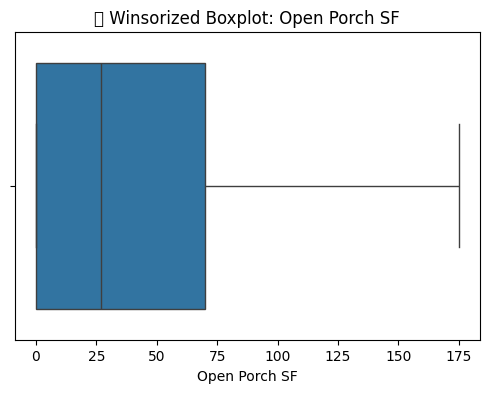

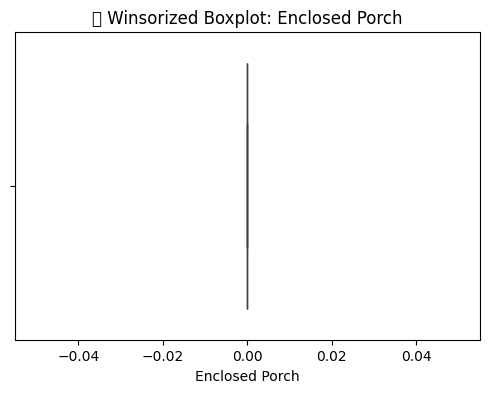

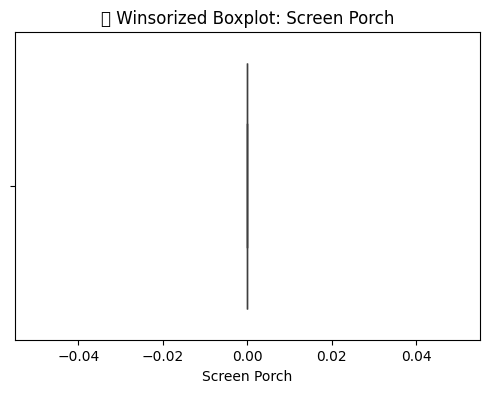

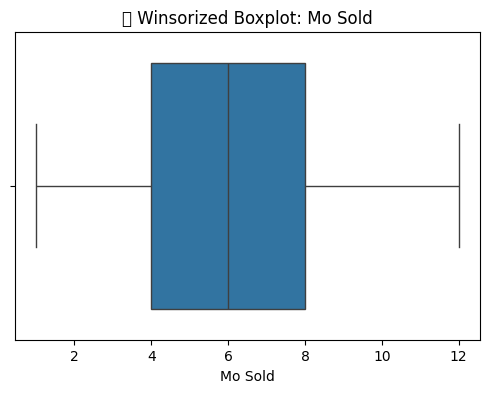

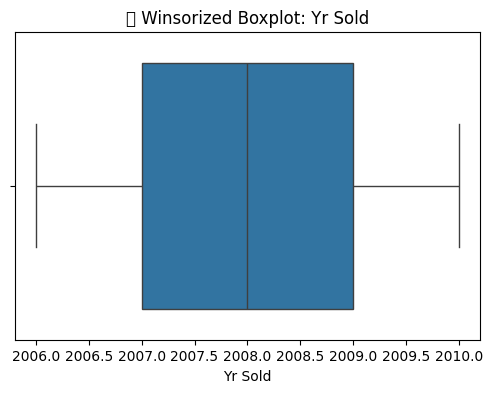

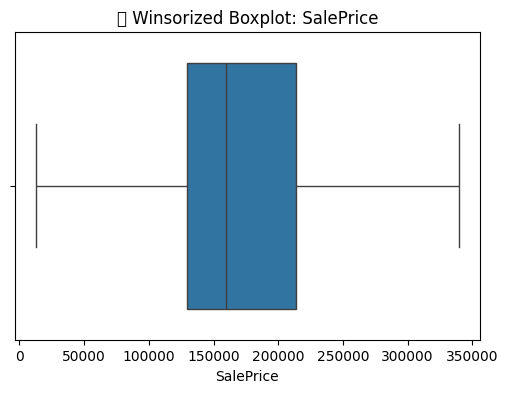

In [225]:
import seaborn as sns
import matplotlib.pyplot as plt

# Her sayısal değişken için boxplot (temizlenmiş veriyle)
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df_winsorized[col])
    plt.title(f'📦 Winsorized Boxplot: {col}')
    plt.show()


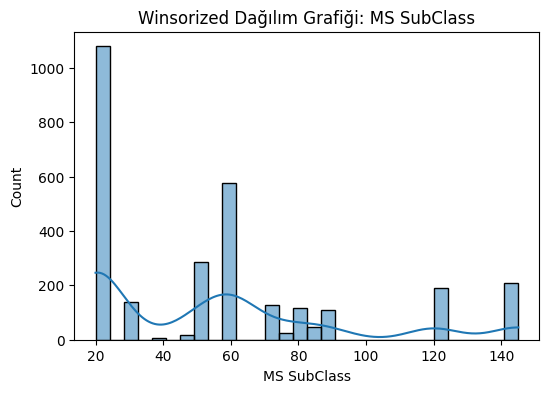

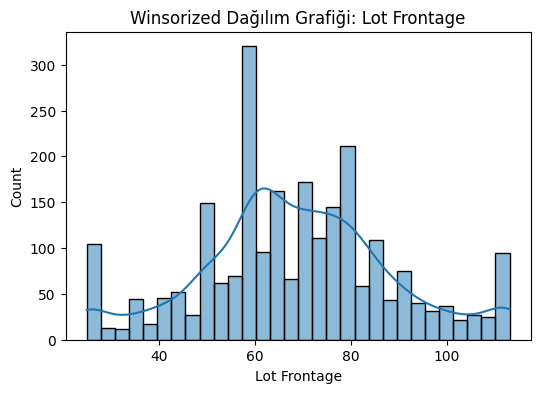

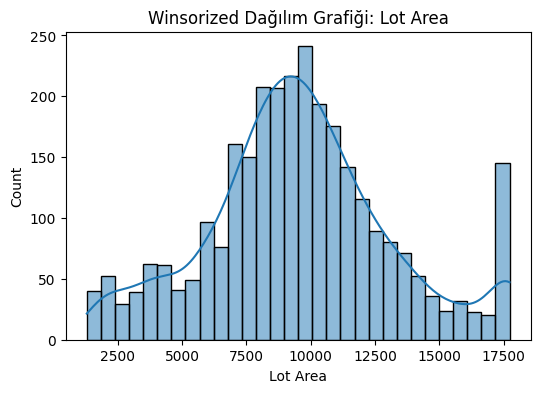

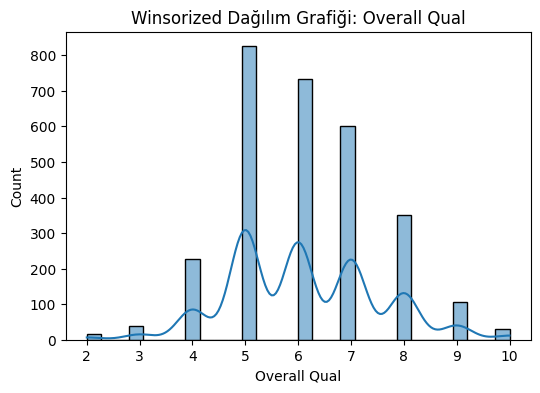

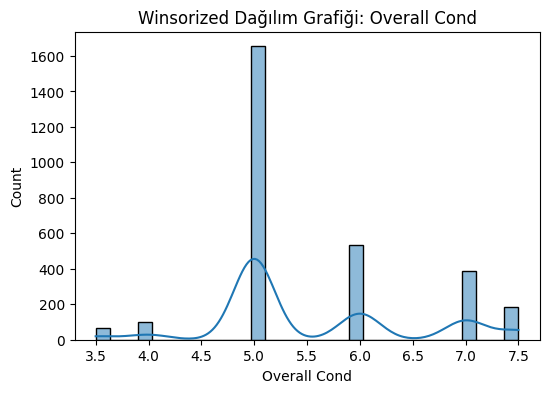

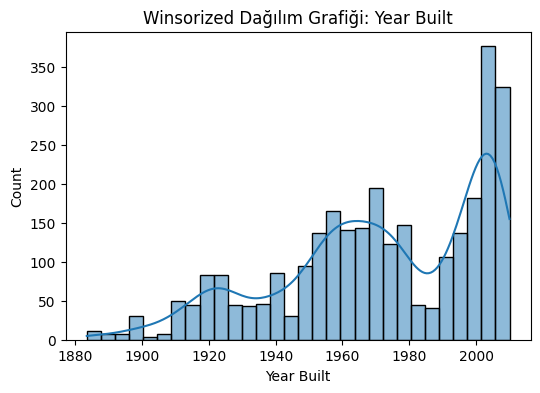

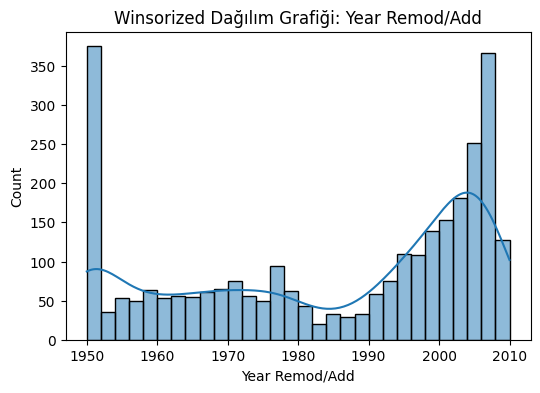

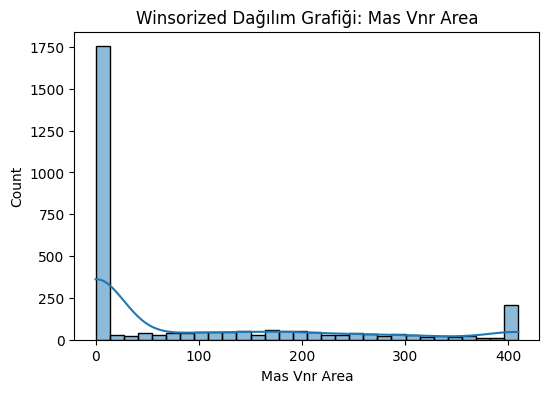

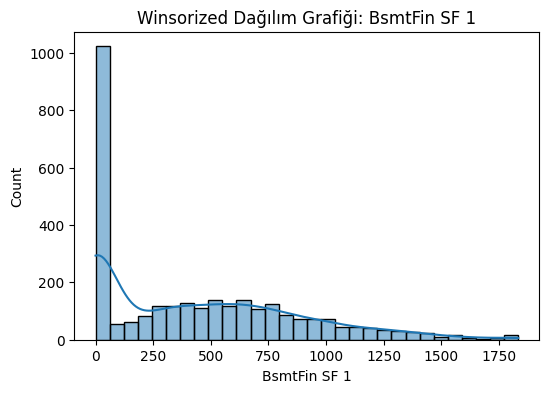

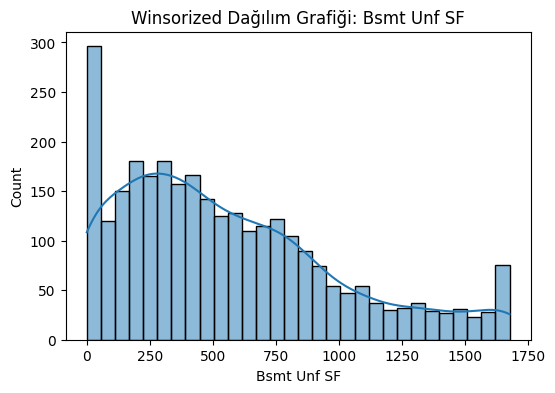

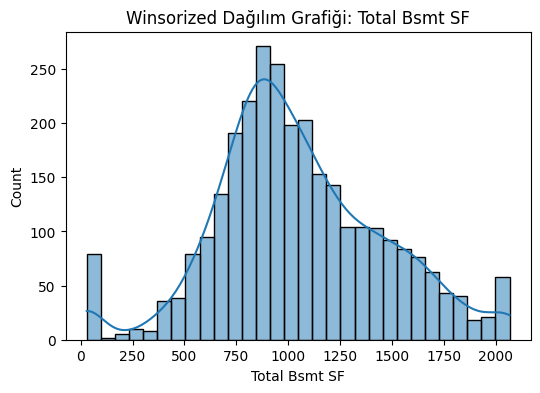

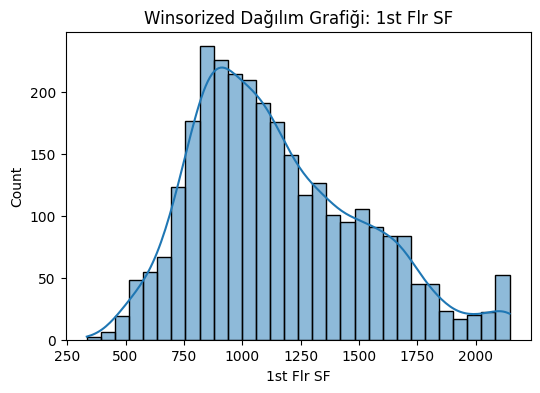

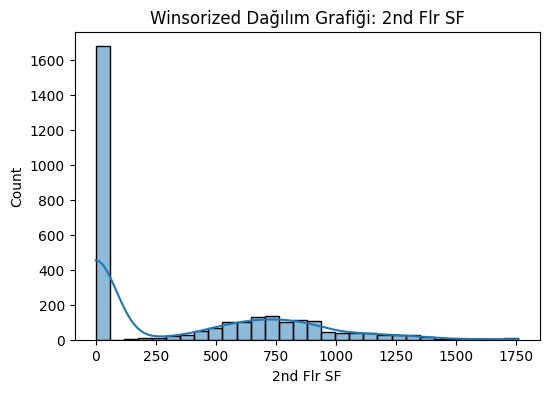

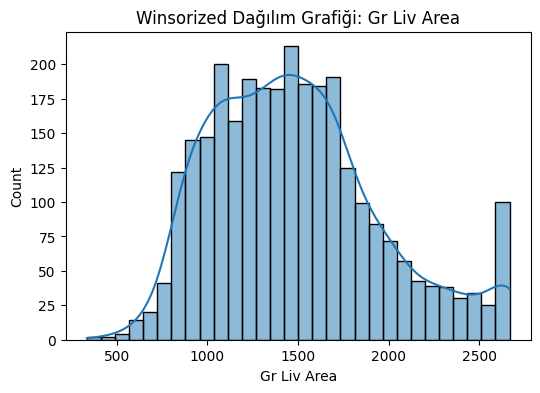

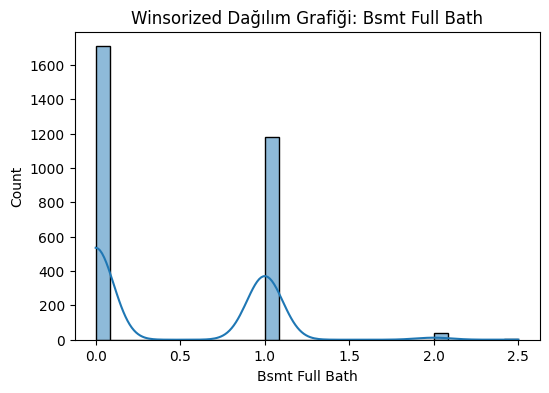

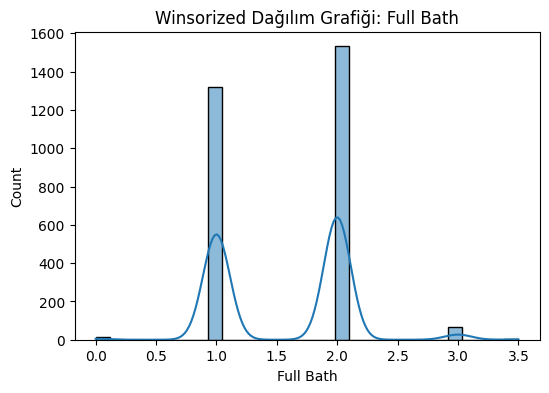

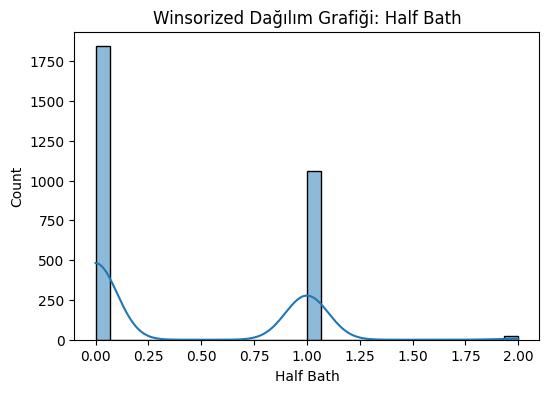

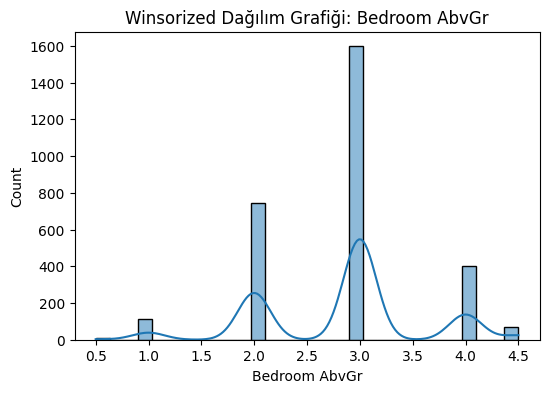

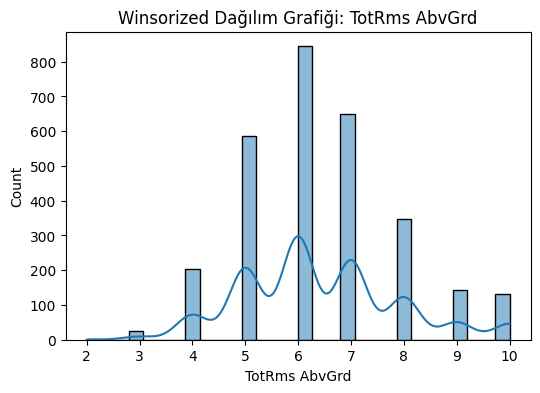

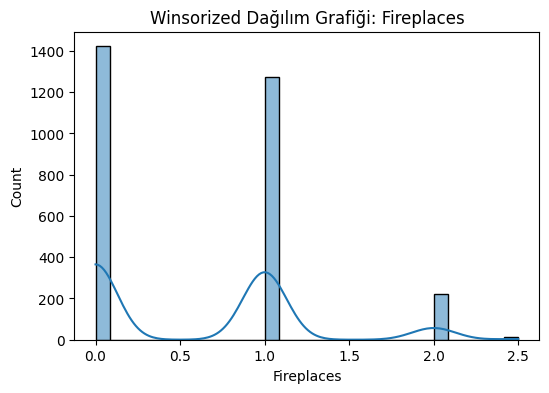

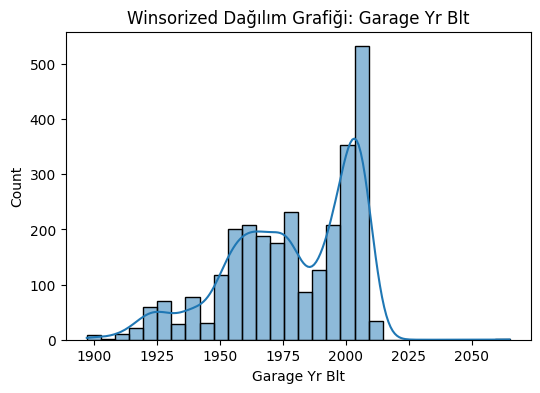

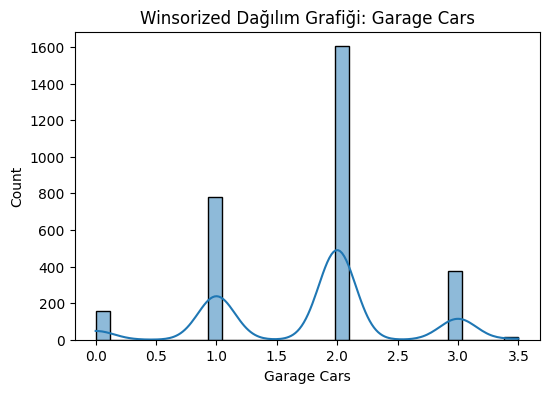

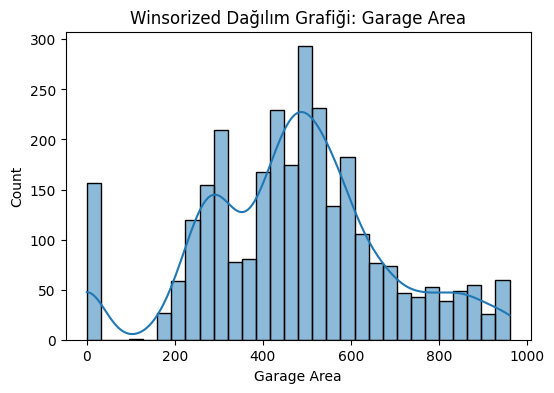

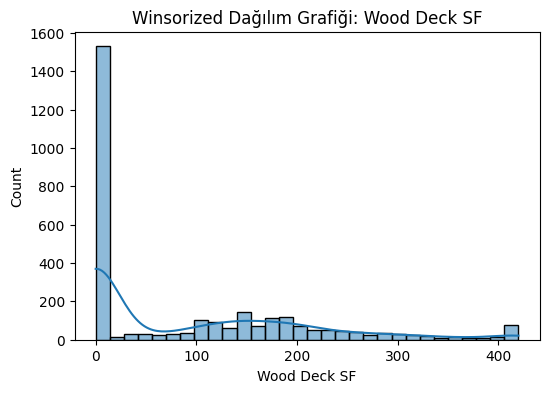

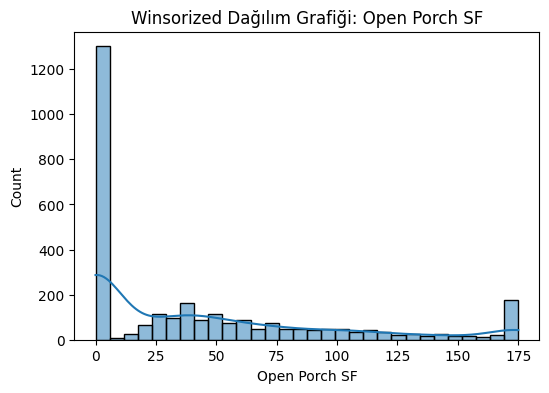

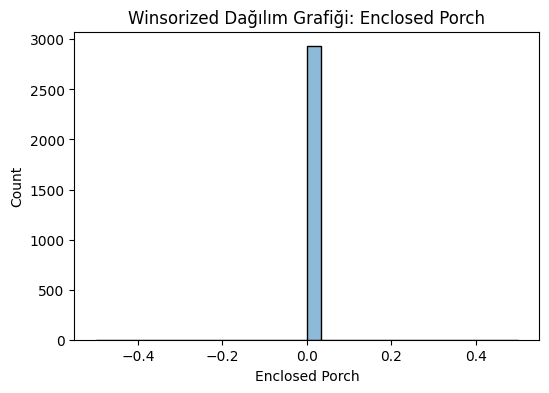

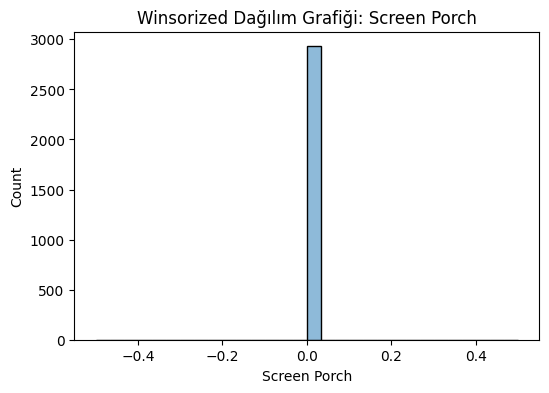

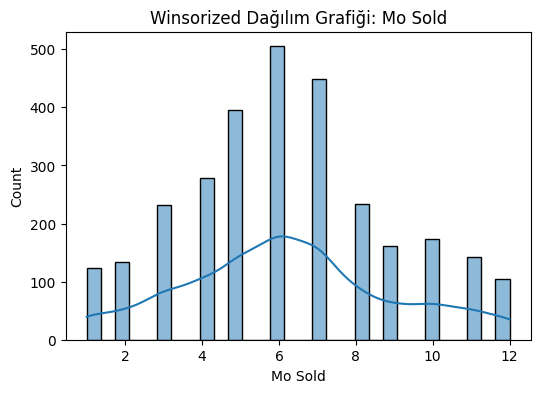

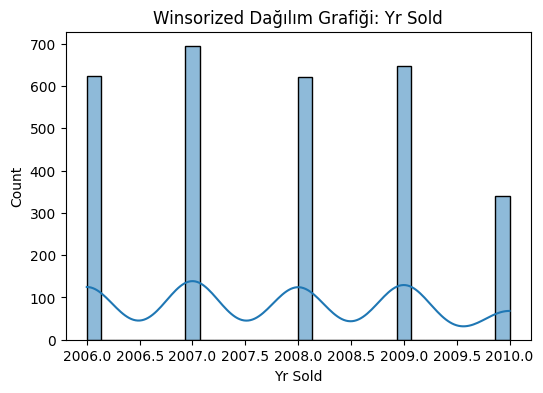

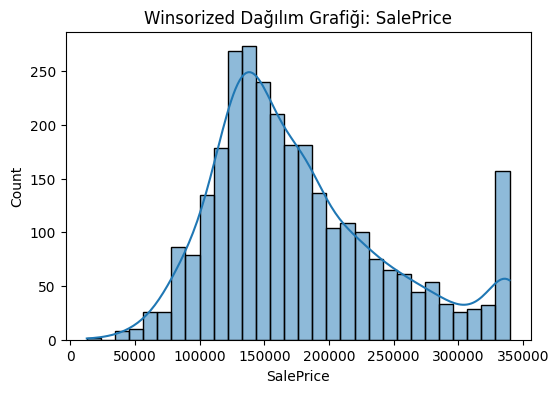

In [226]:
# Her sayısal değişken için dağılım grafiği (temizlenmiş veriyle)
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_winsorized[col], kde=True, bins=30)
    plt.title(f'Winsorized Dağılım Grafiği: {col}')
    plt.show()


In [227]:
# Kategorik sütunları al (object türündeki sütunlar)
categorical_cols = df.select_dtypes(include='object').columns.tolist()

print("🧩 Kategorik değişkenler:")
print(categorical_cols)


🧩 Kategorik değişkenler:
['MS Zoning', 'Lot Shape', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Bldg Type', 'House Style', 'Roof Style', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Paved Drive', 'Sale Type', 'Sale Condition']


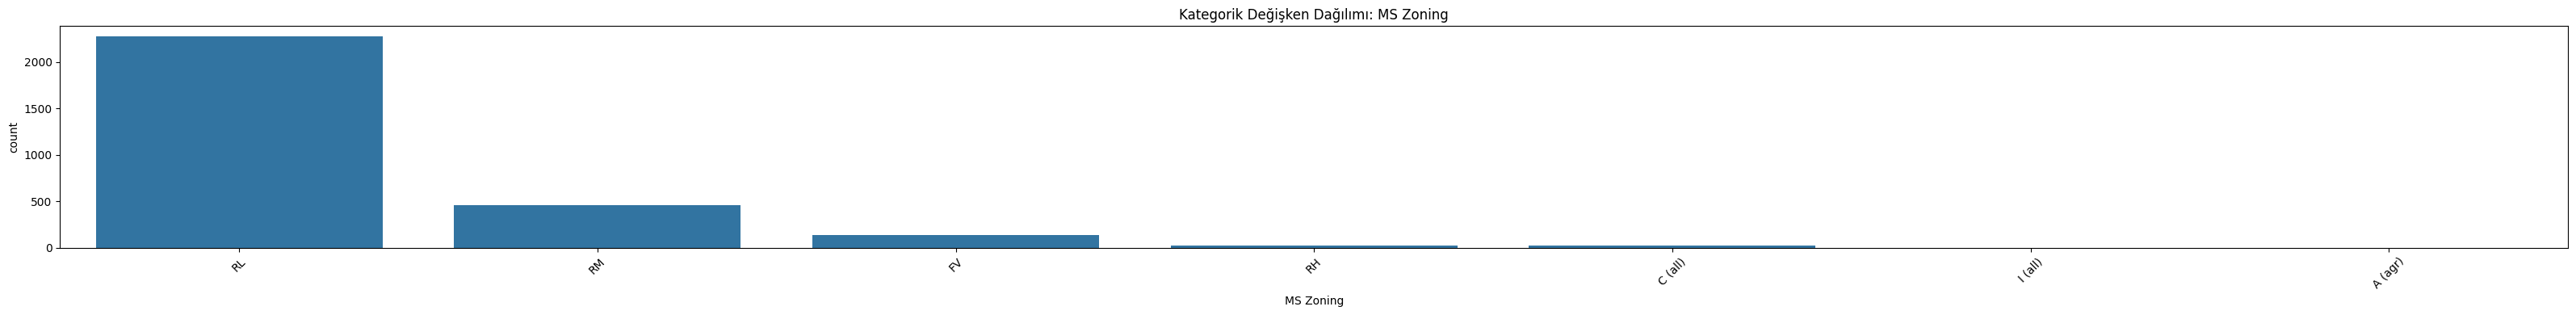

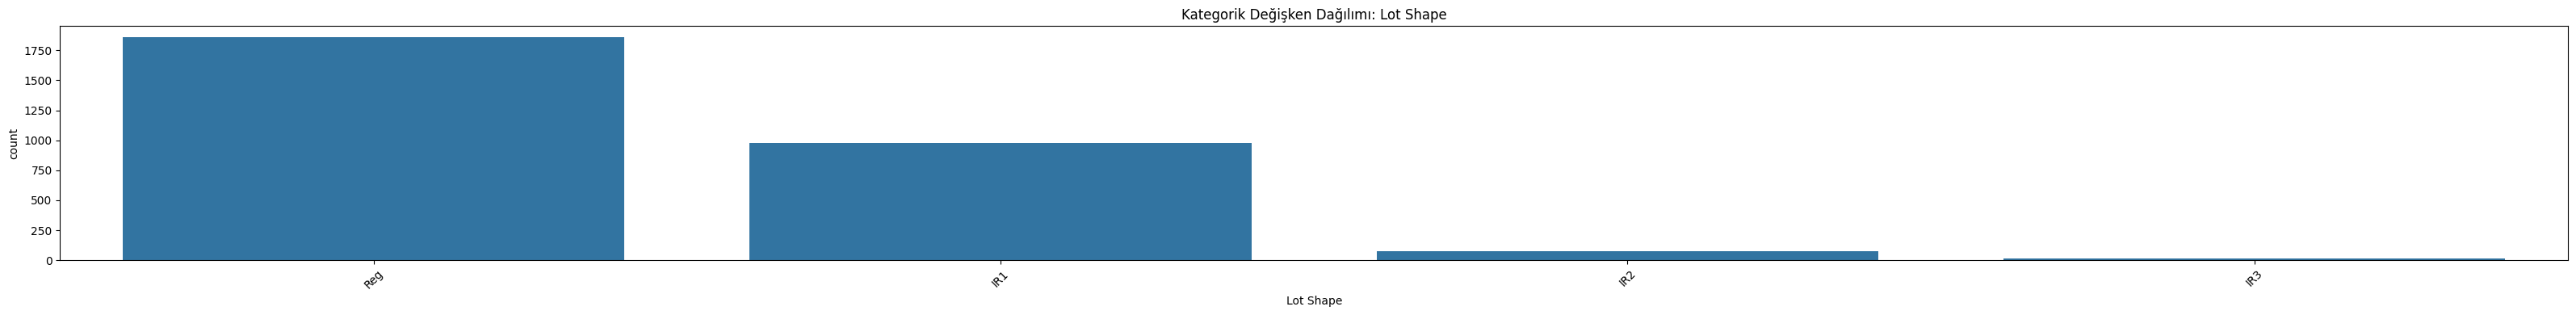

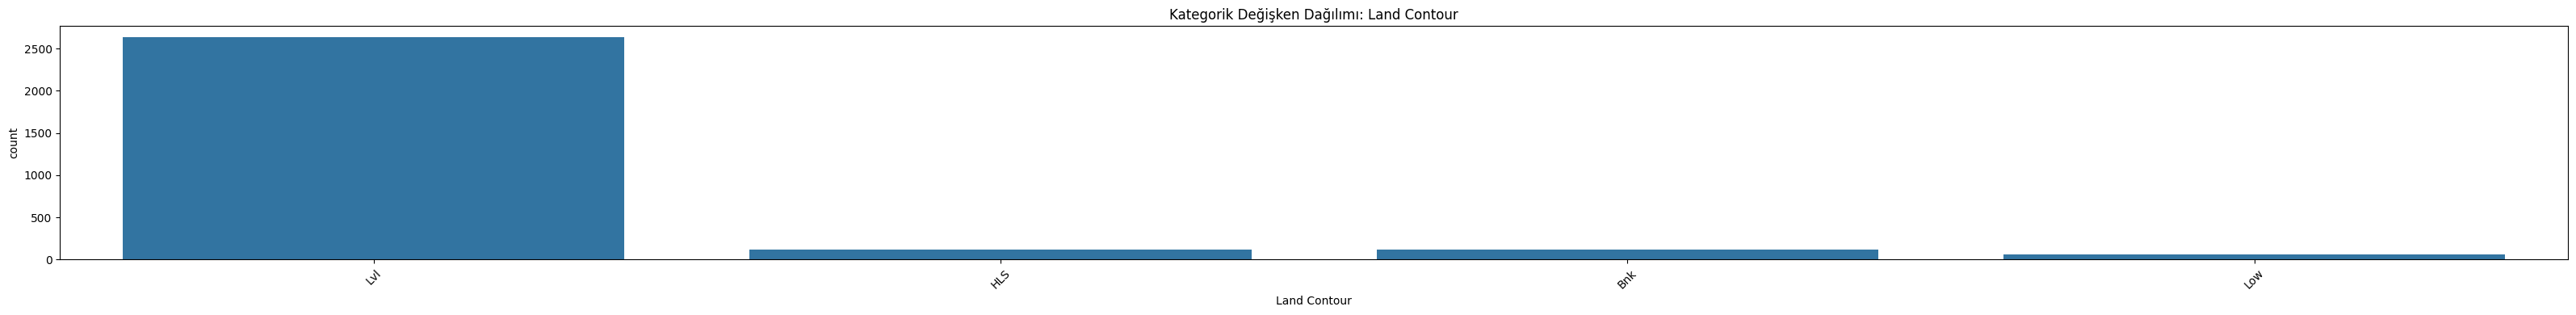

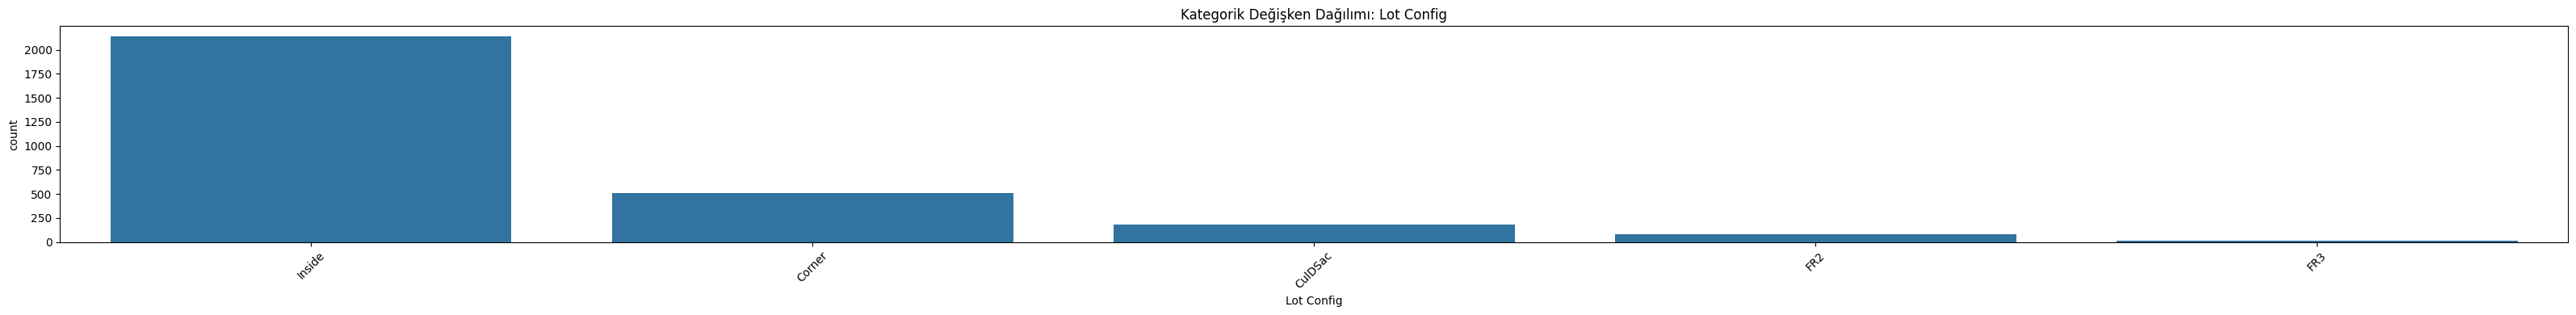

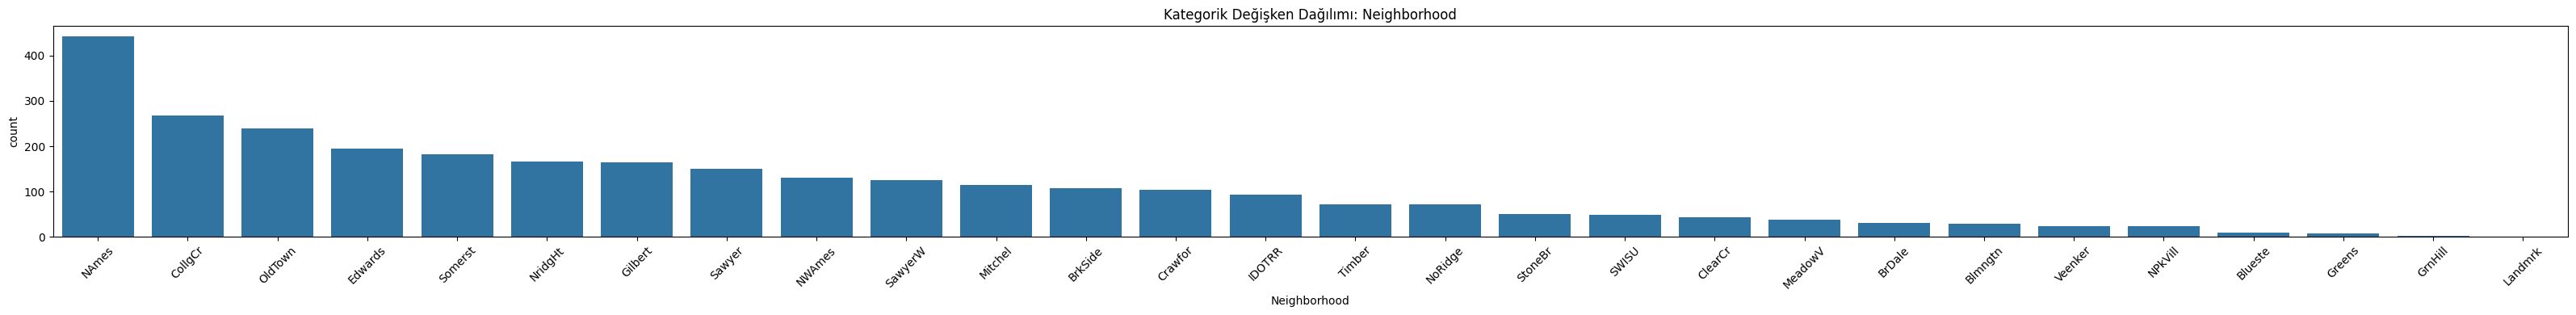

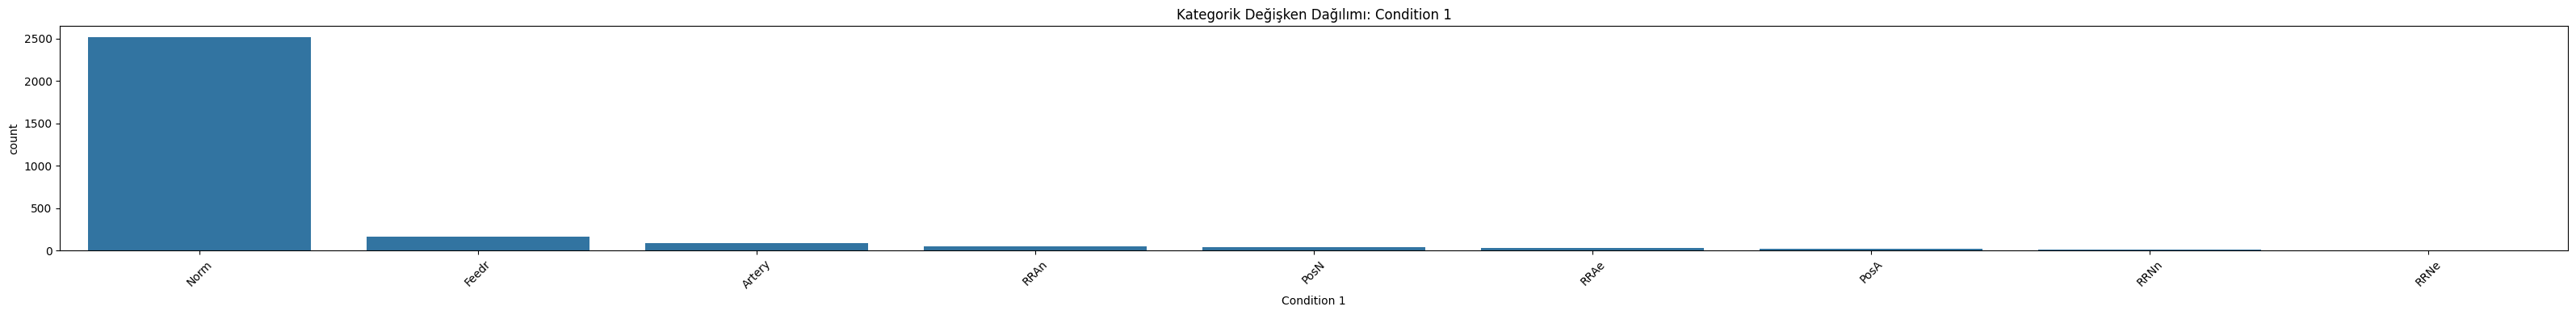

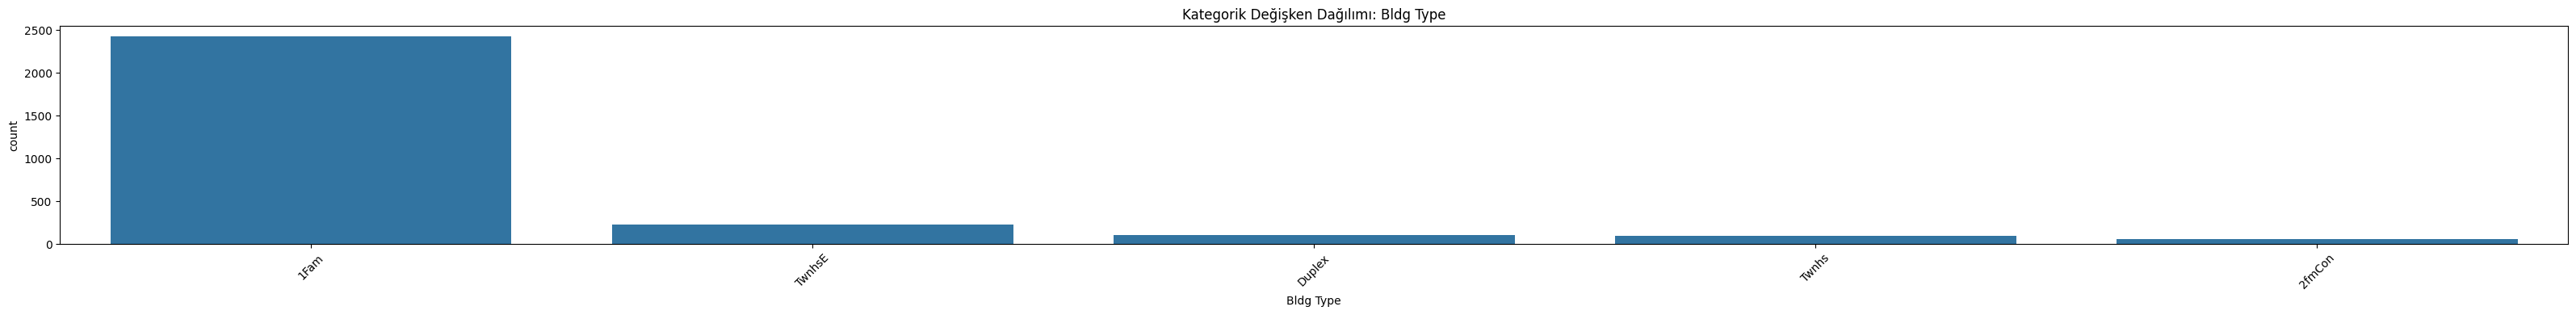

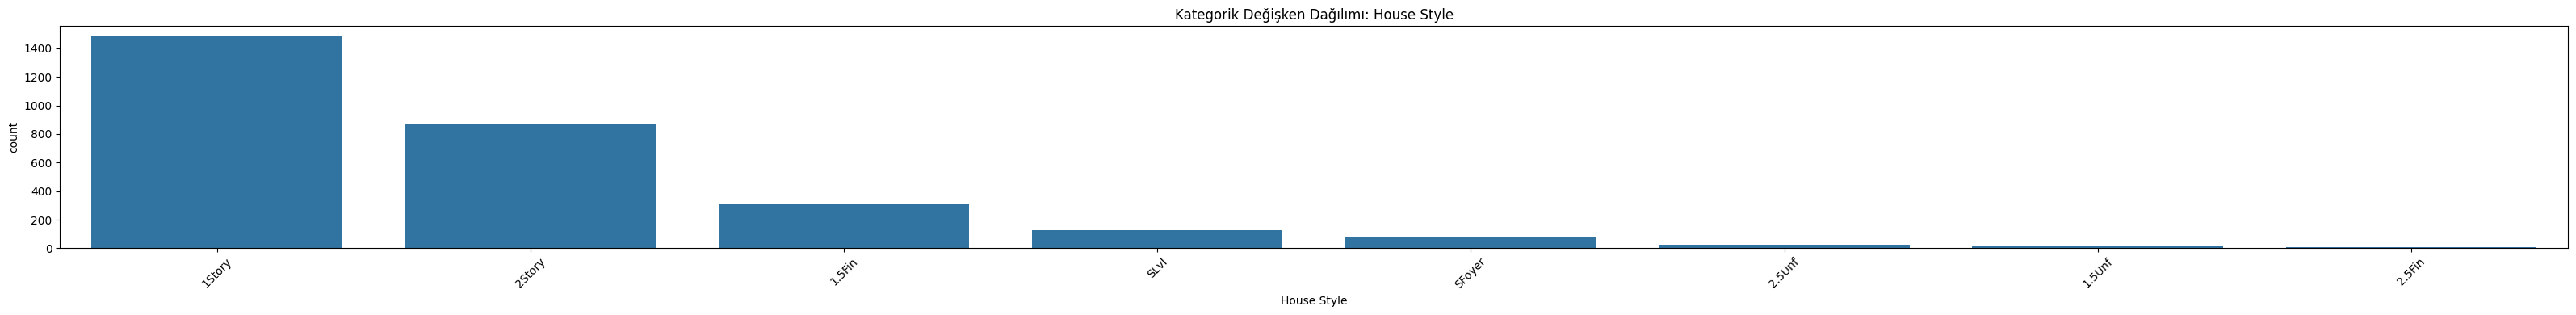

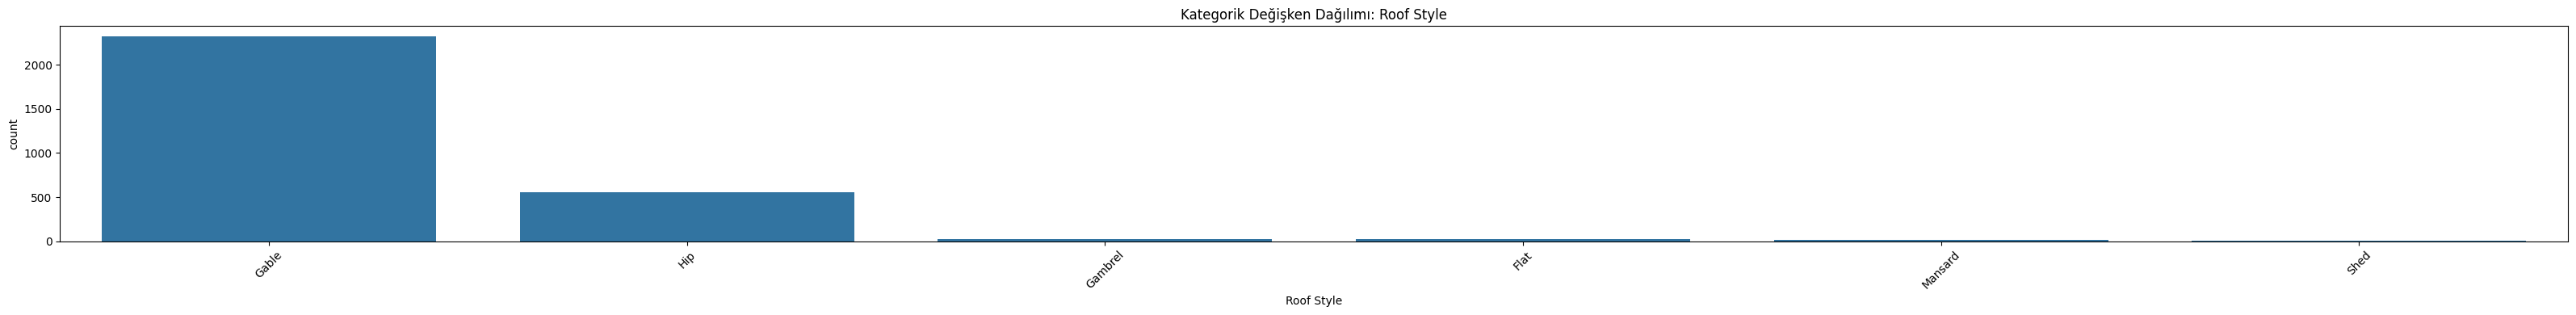

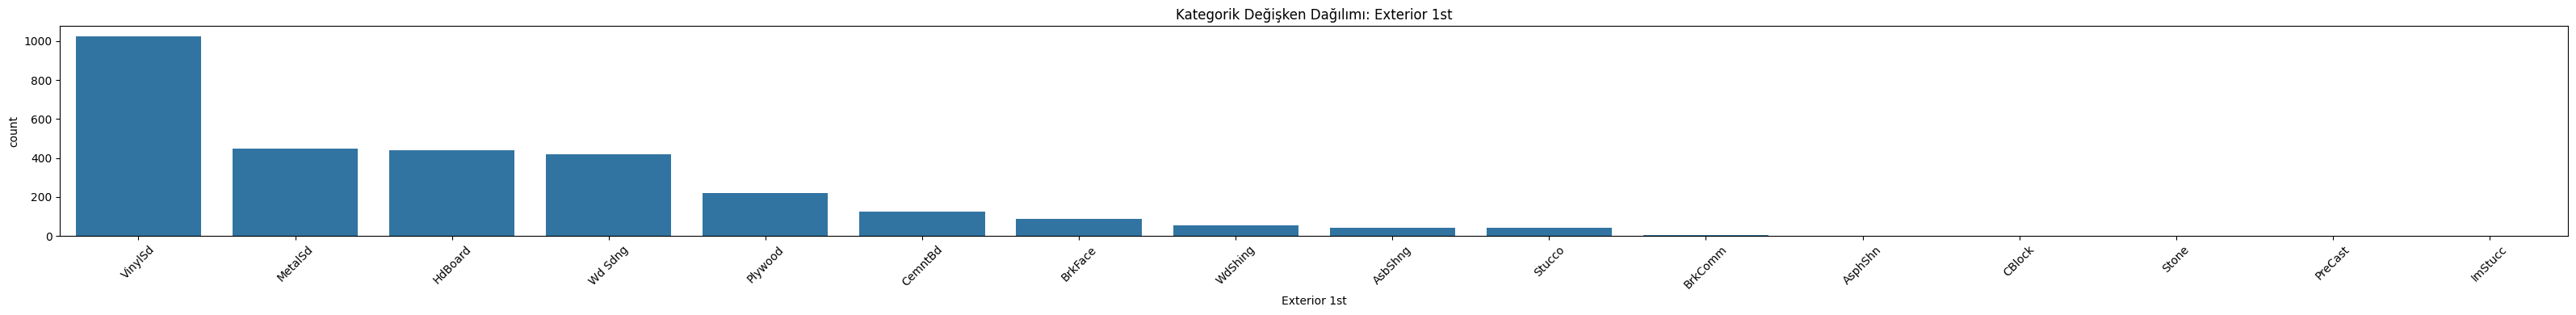

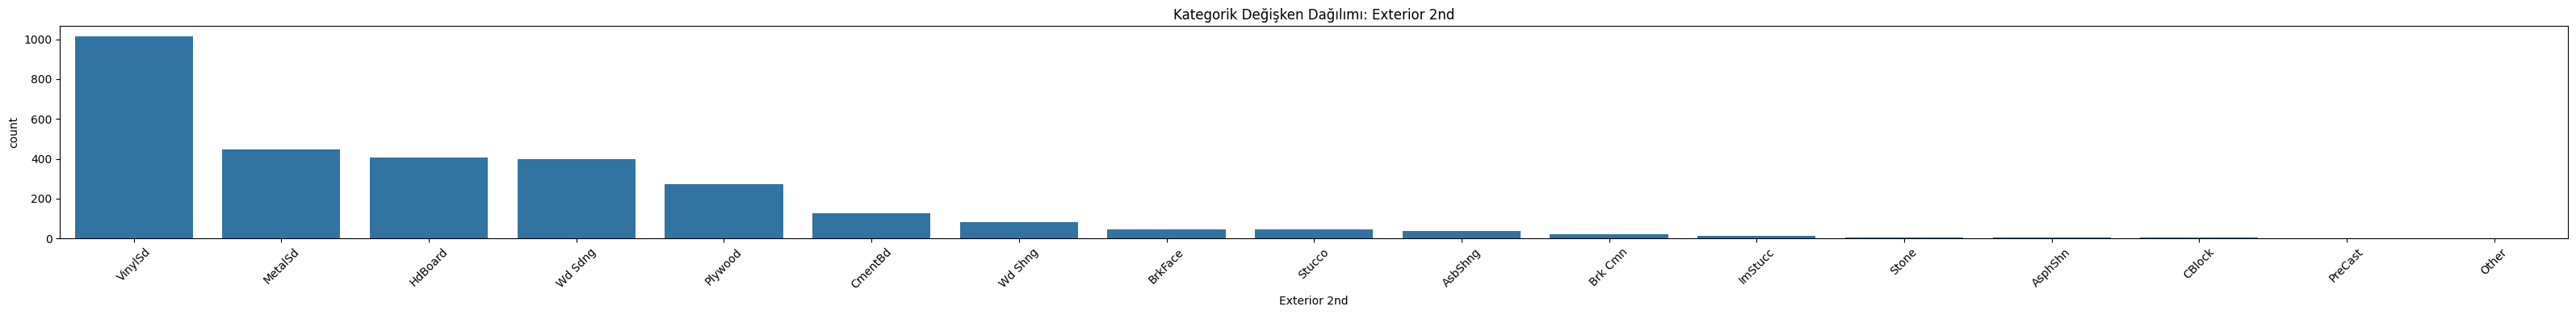

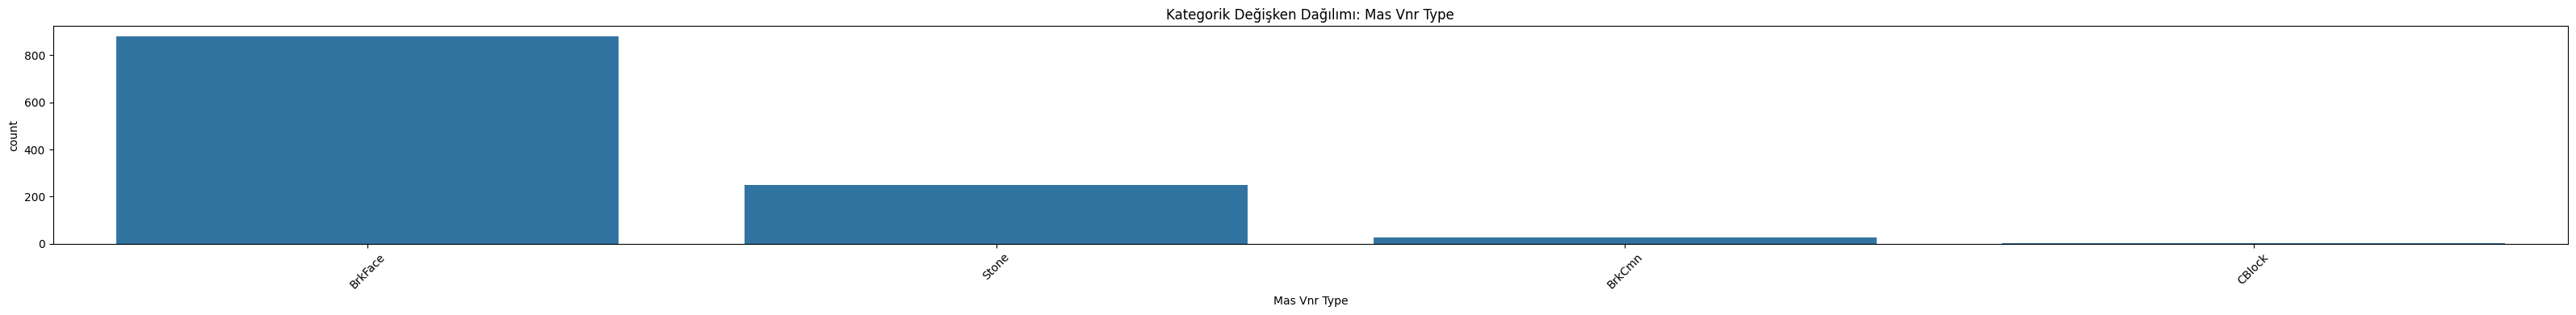

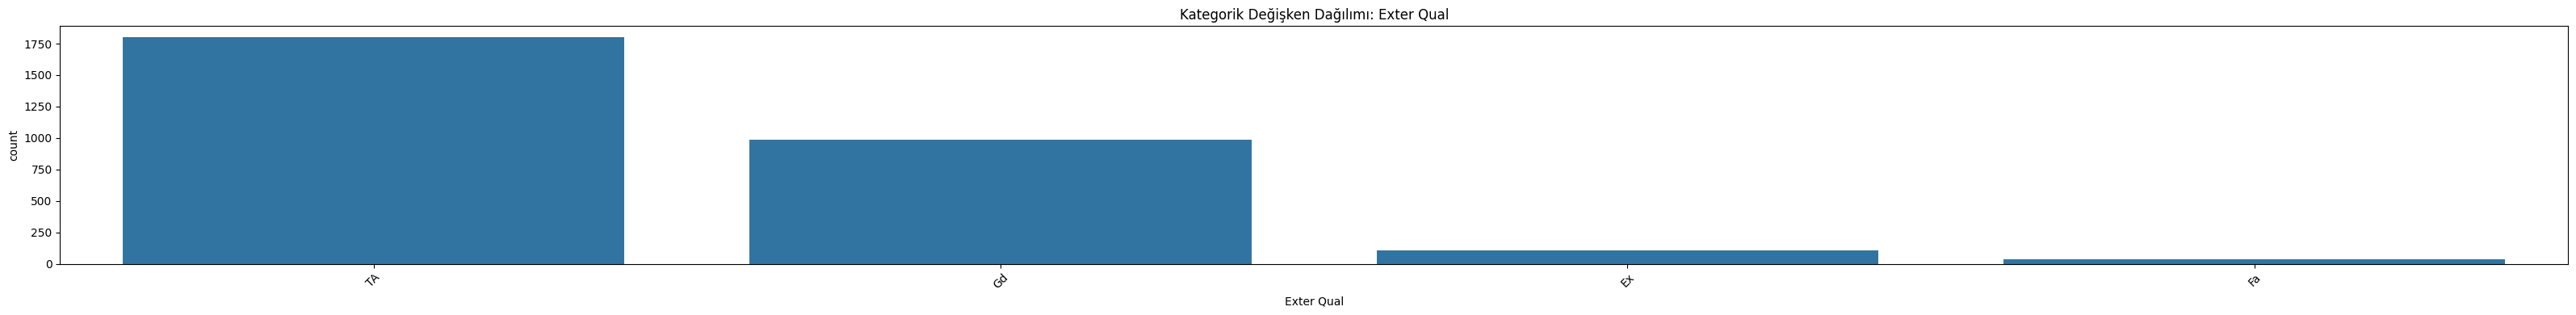

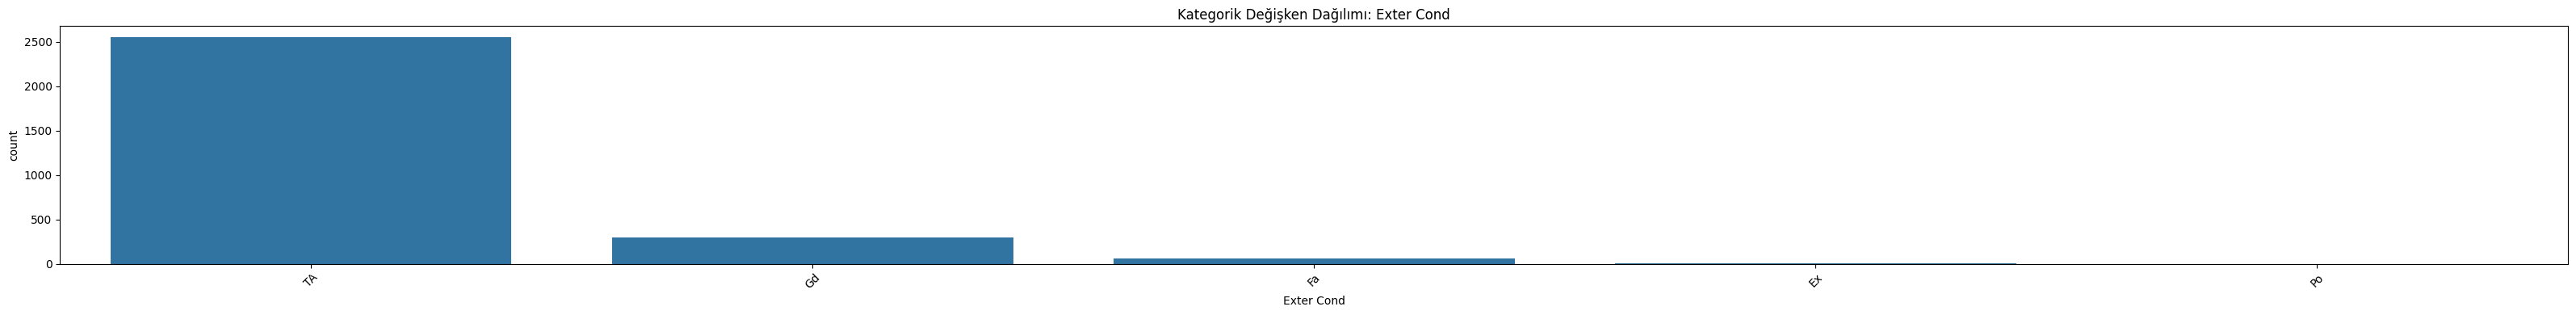

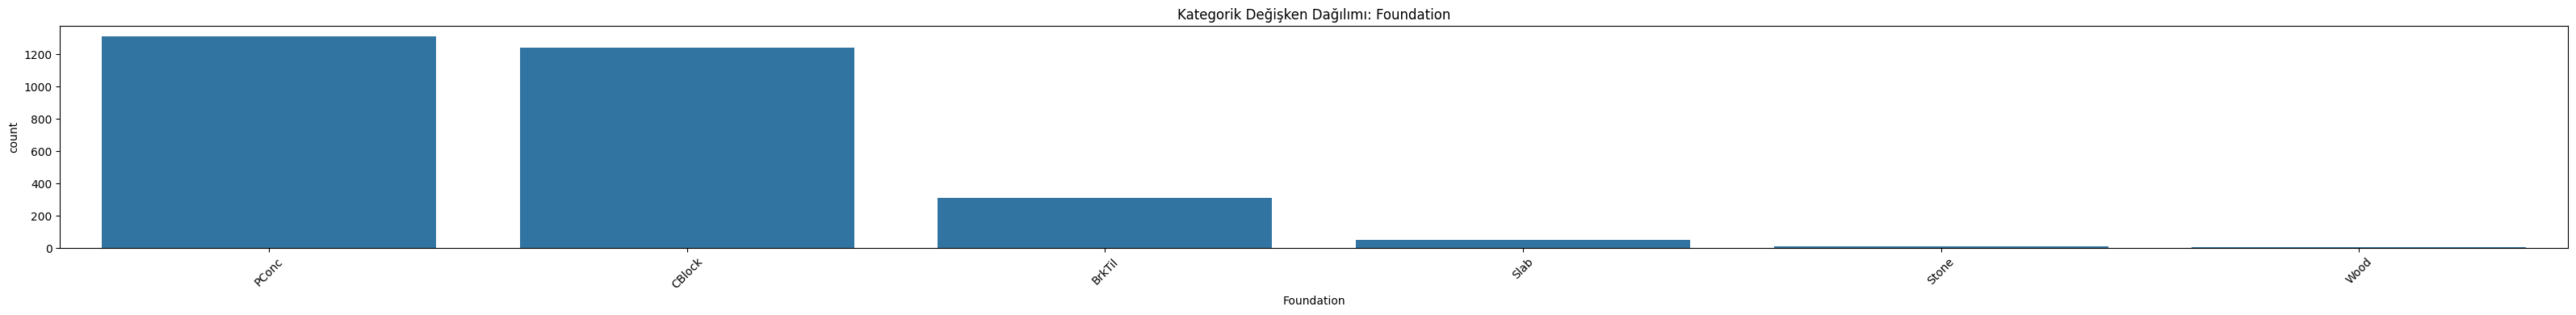

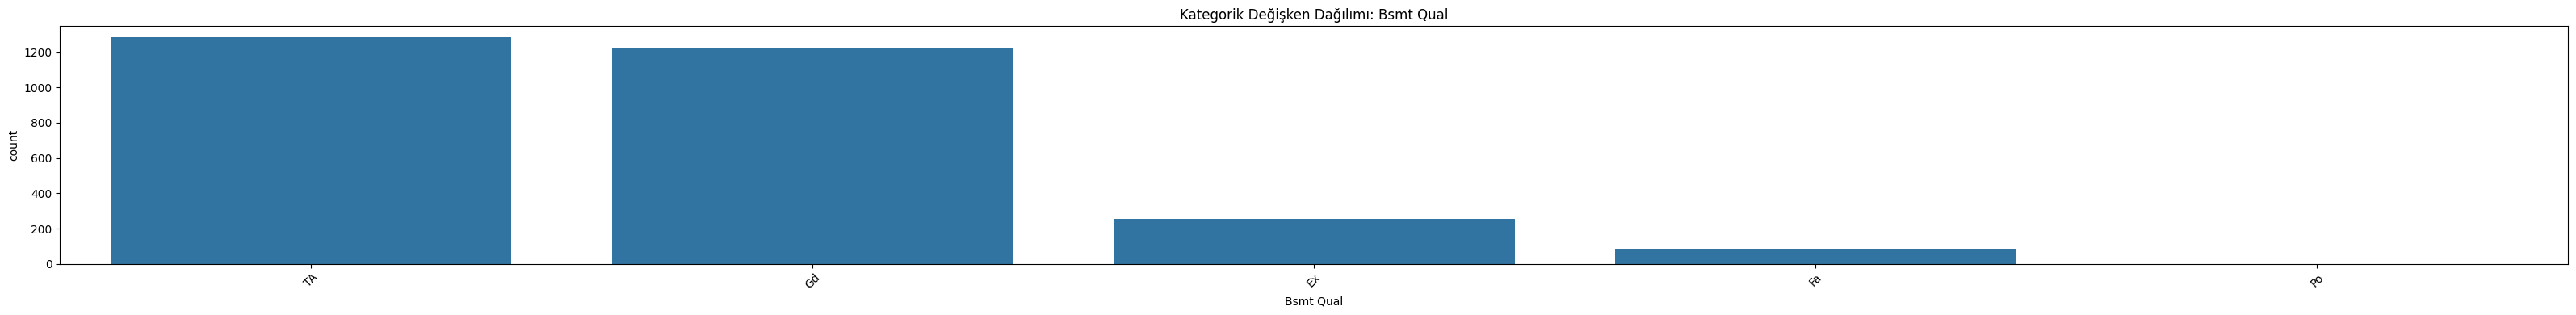

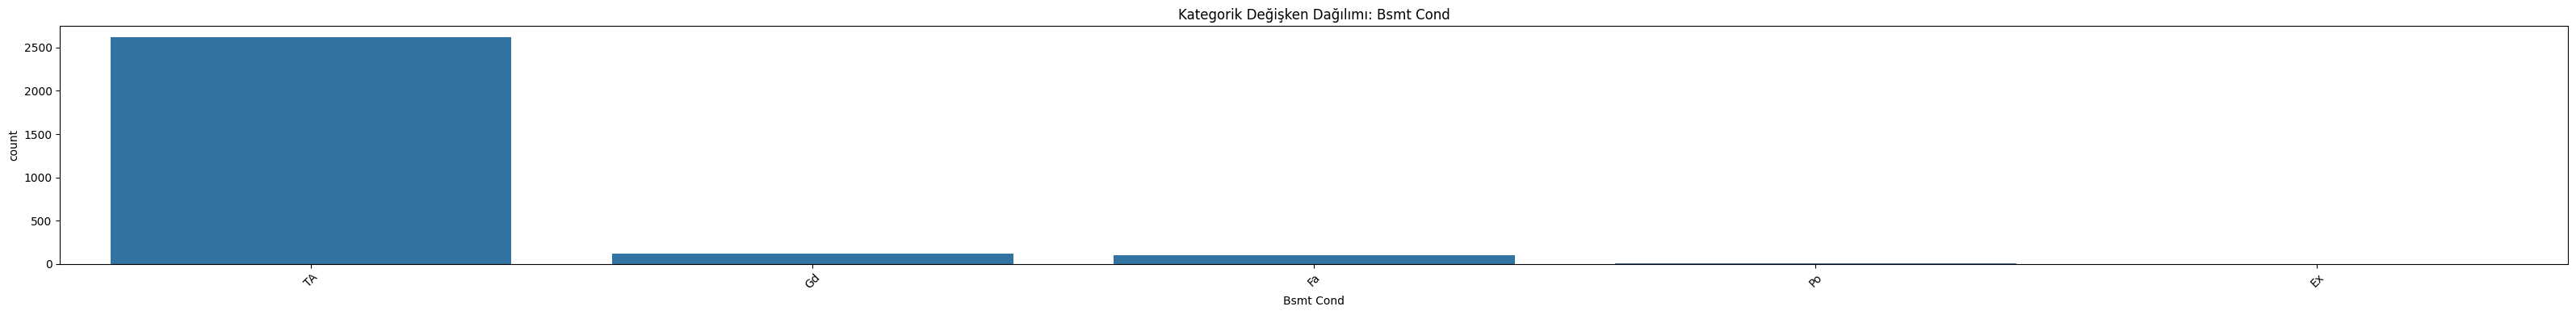

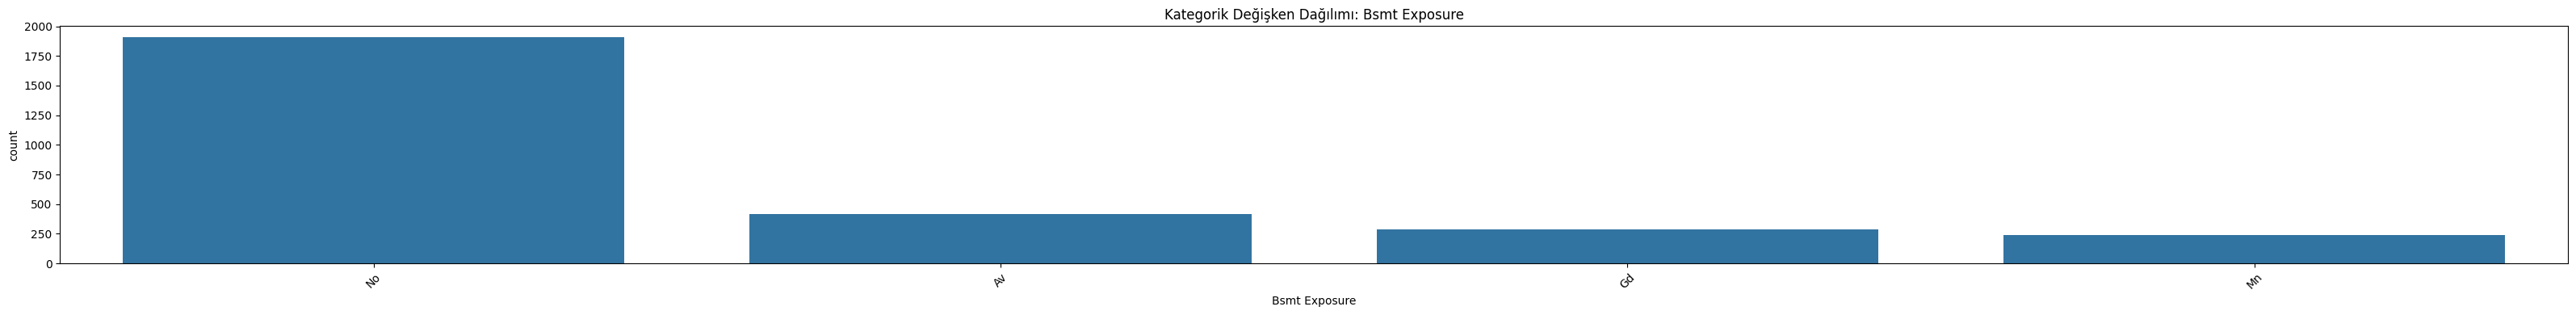

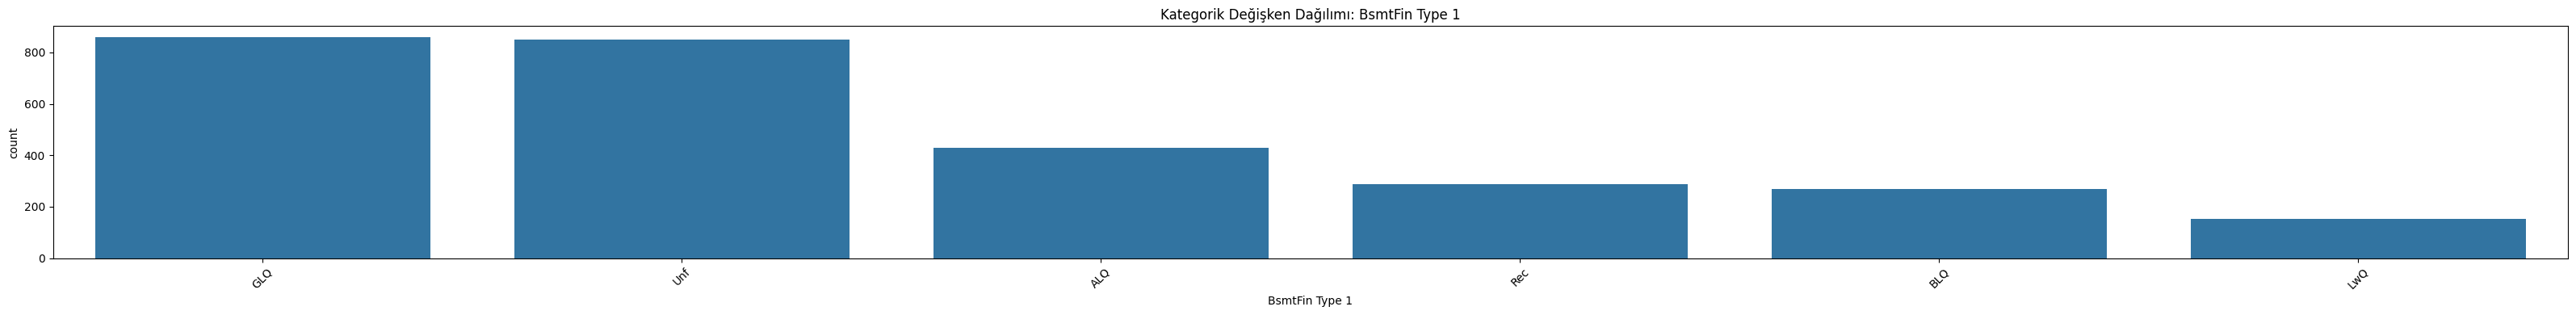

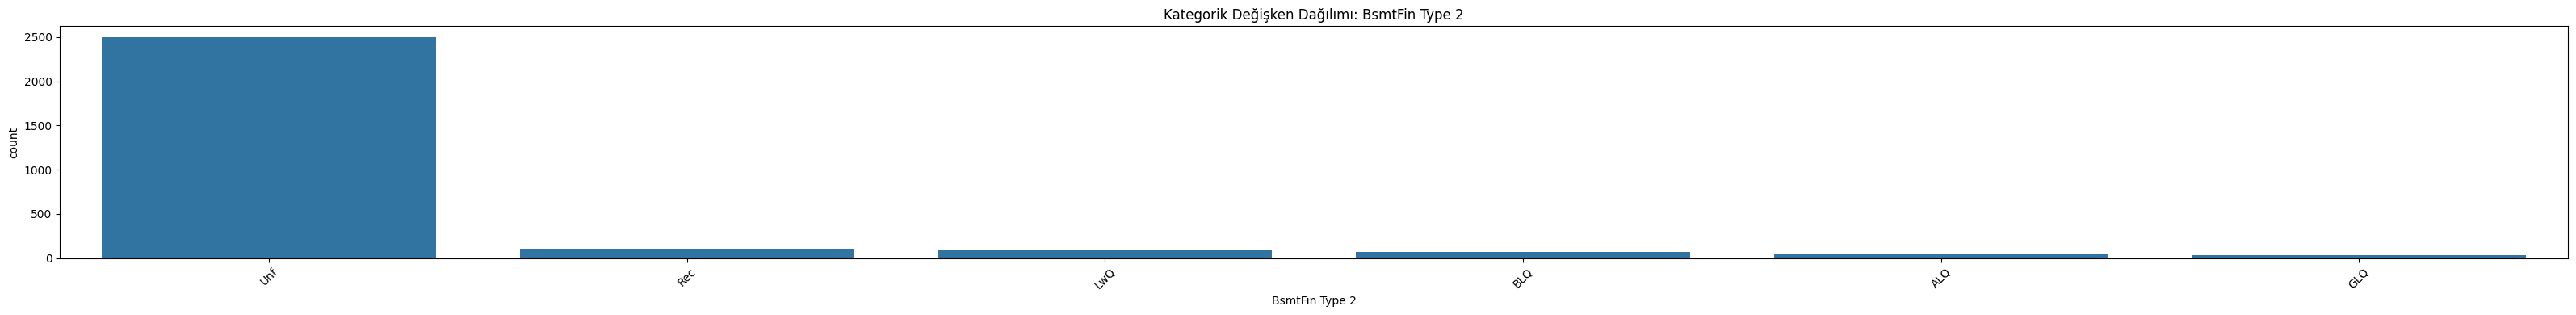

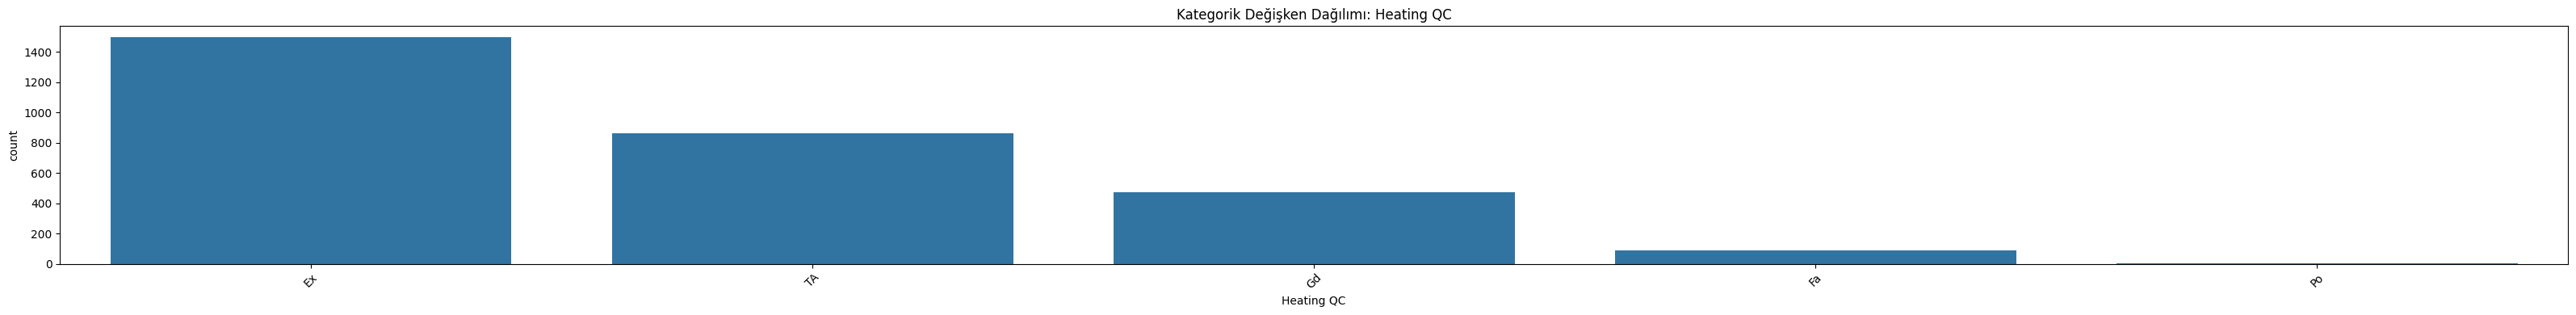

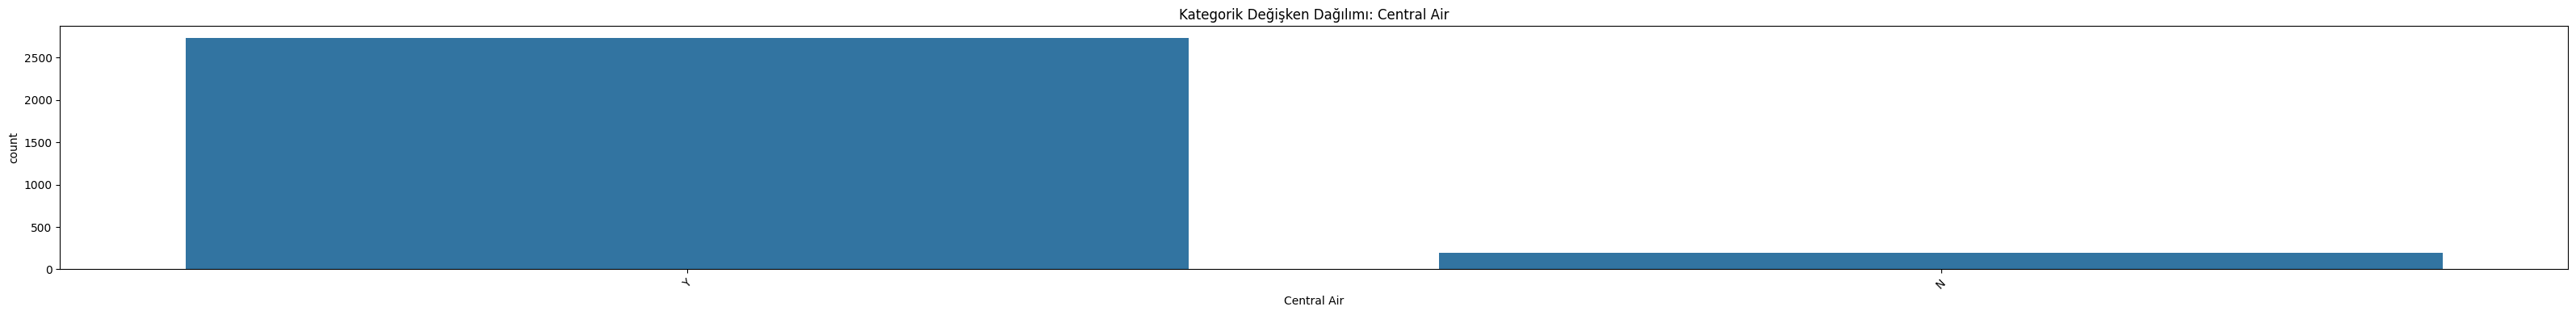

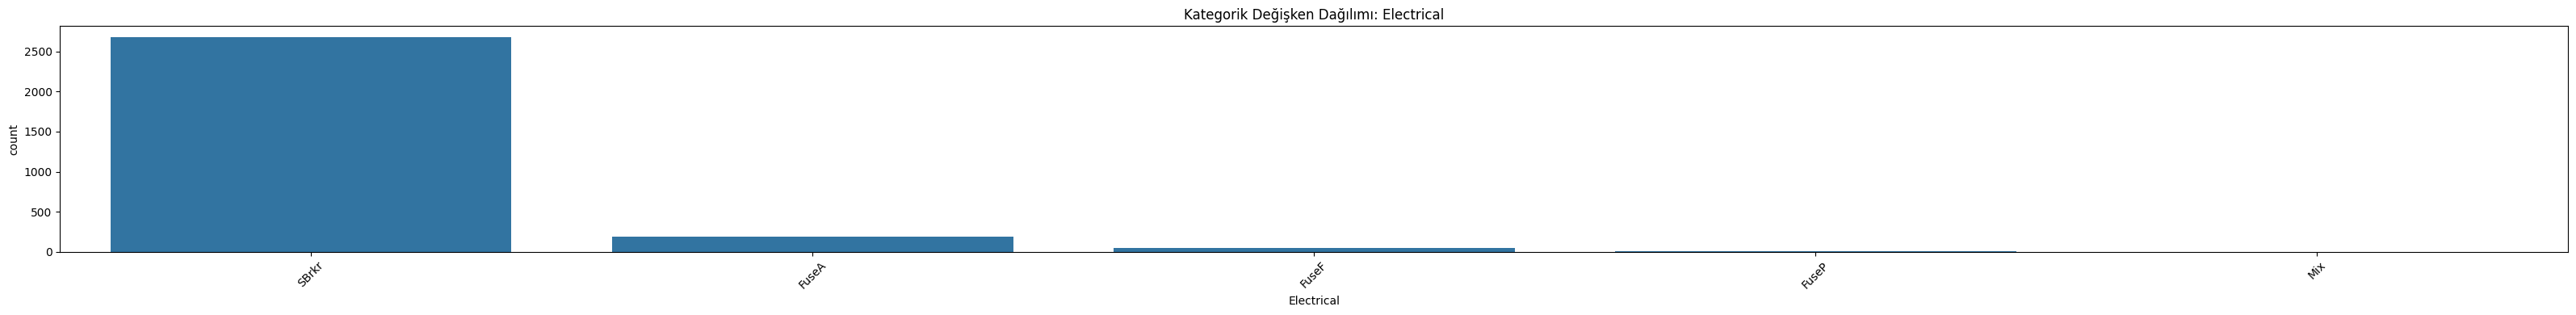

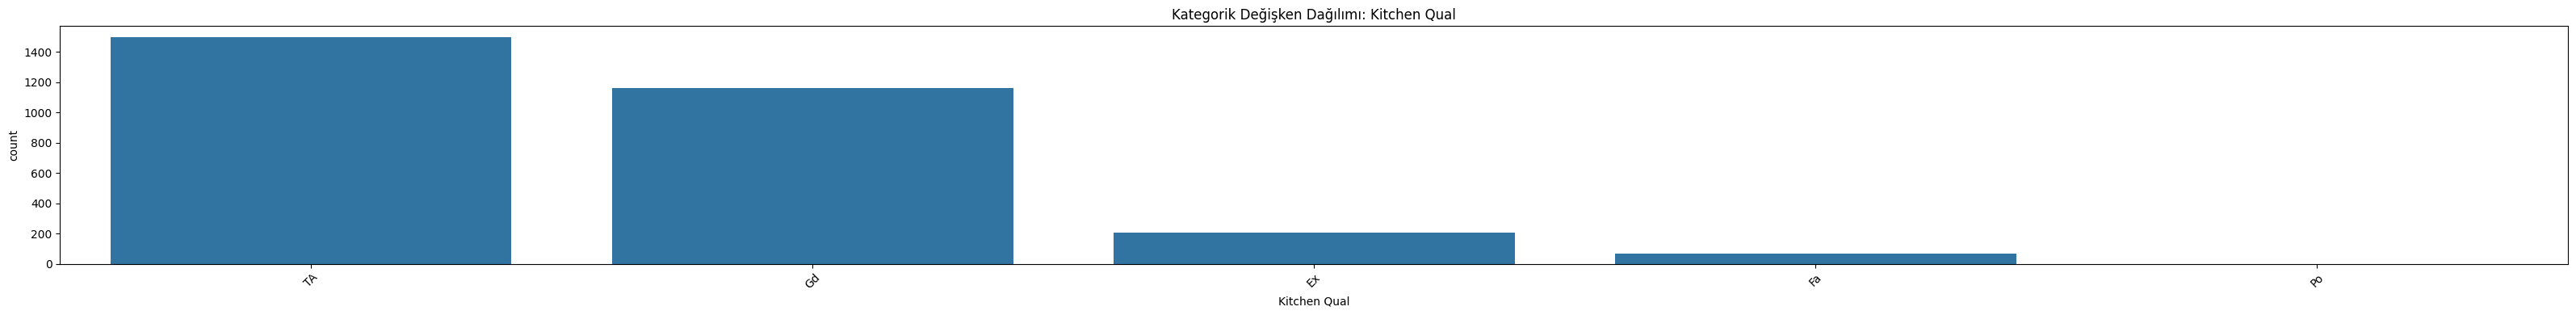

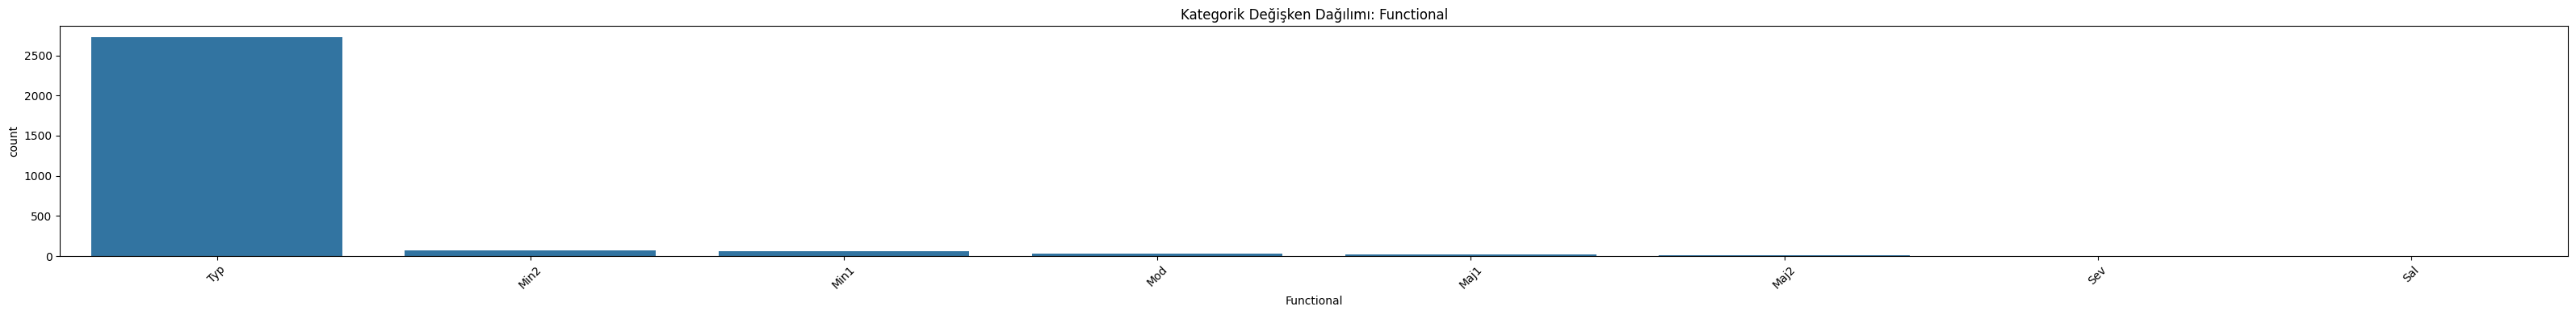

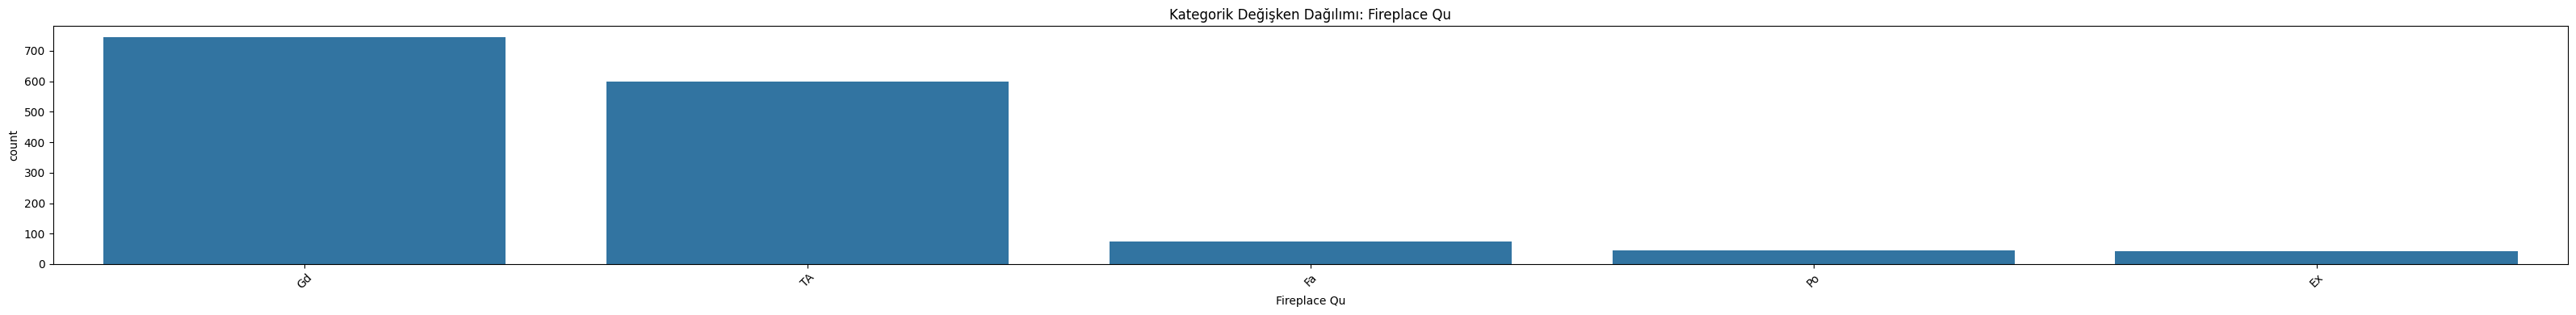

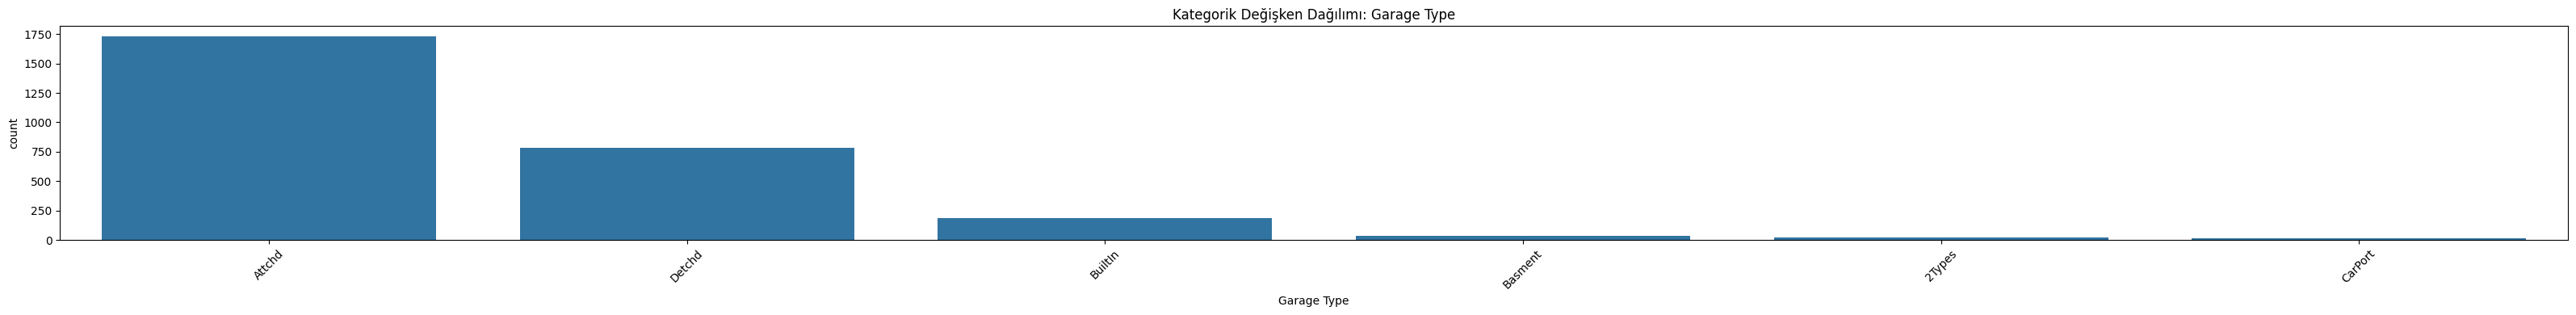

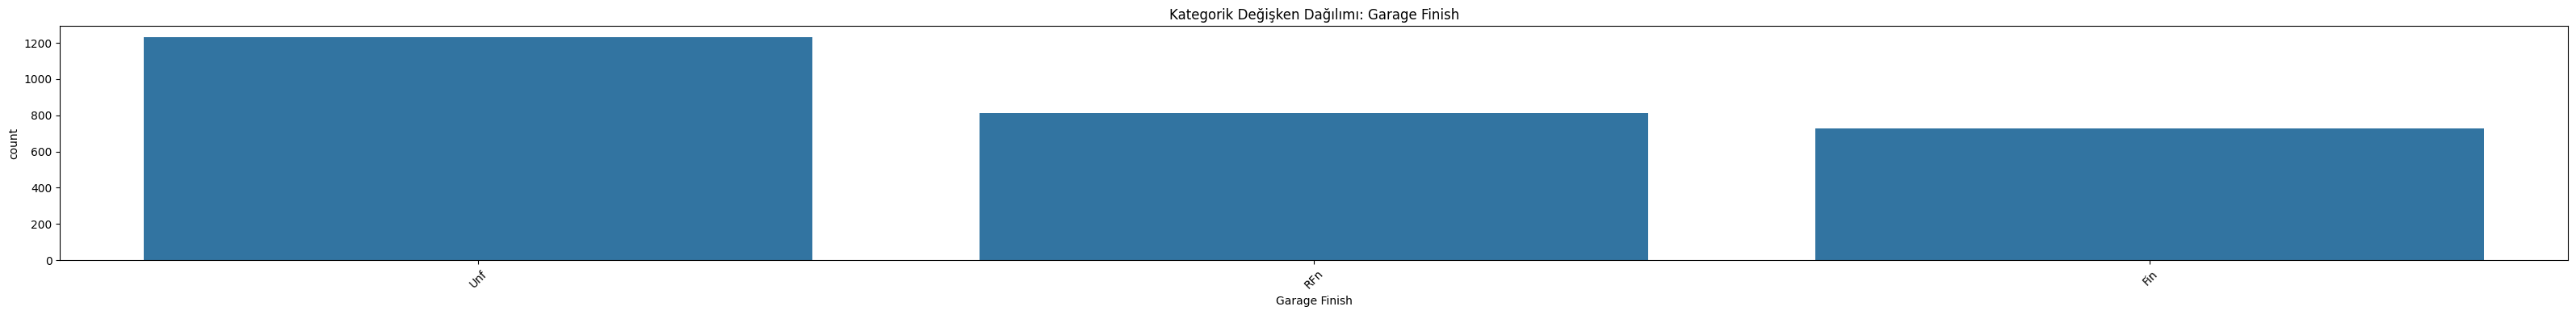

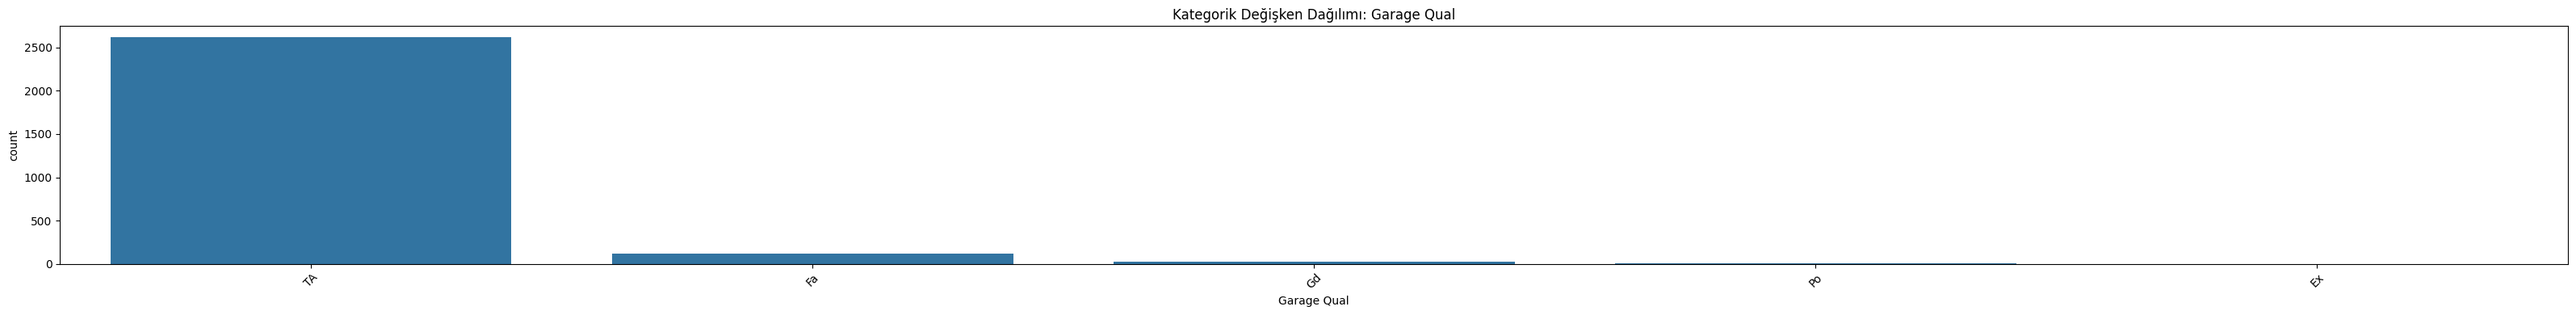

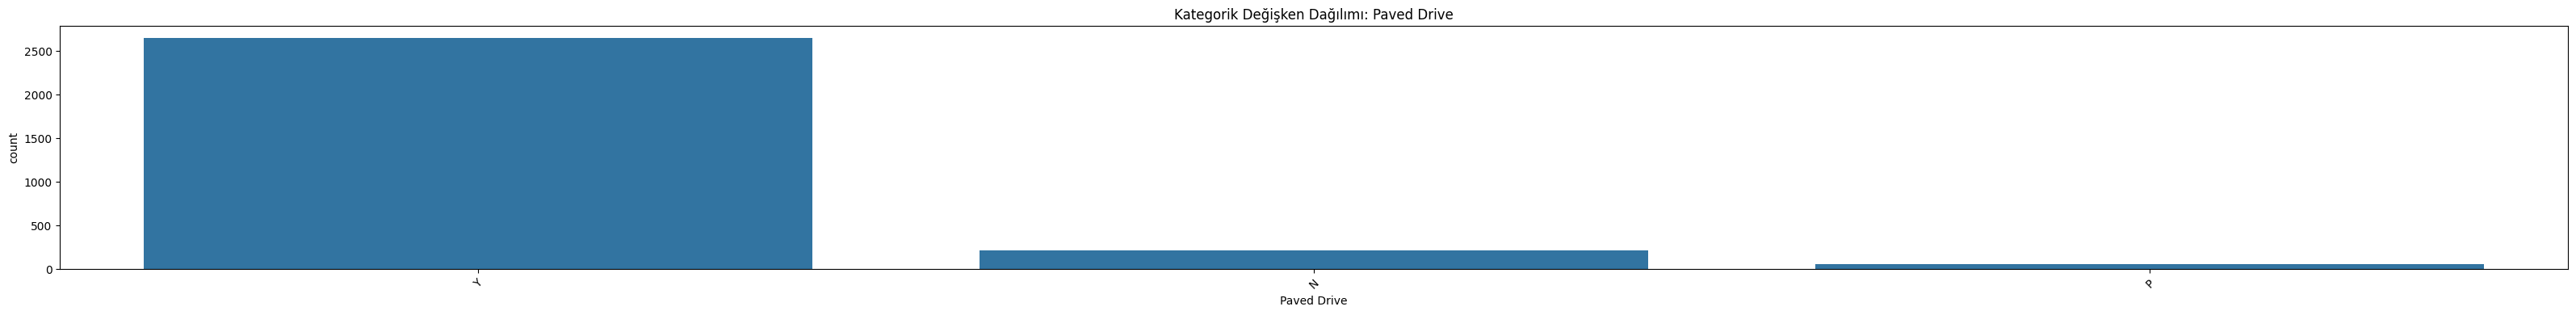

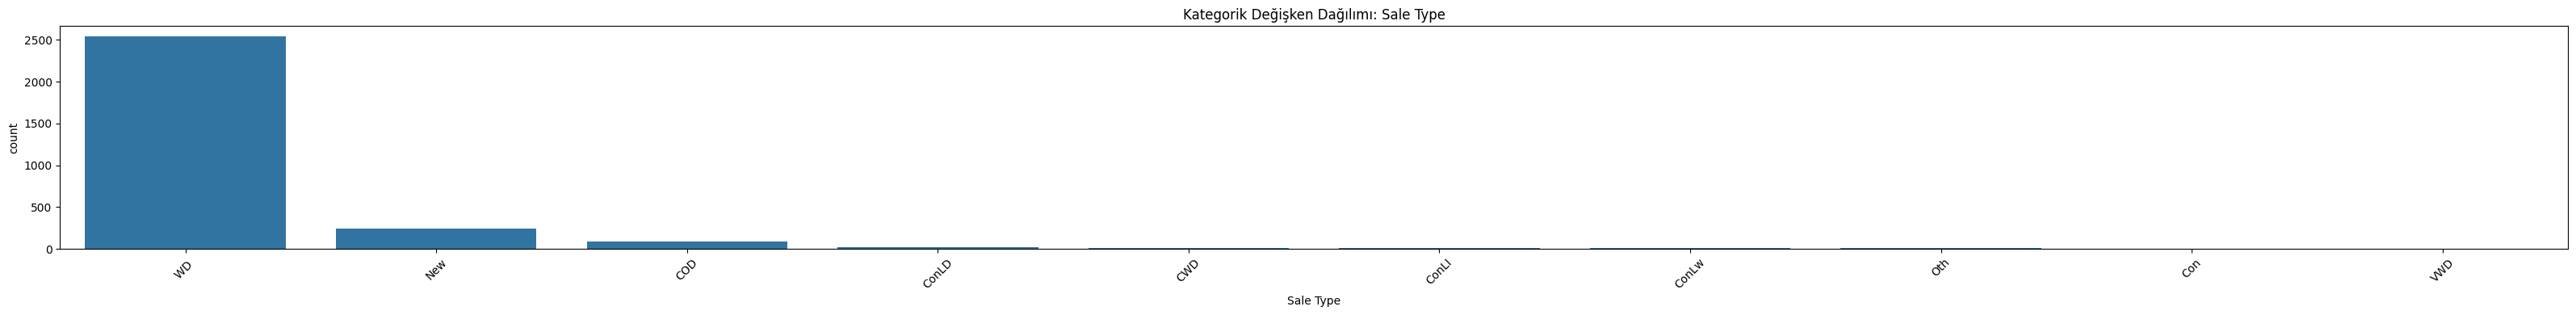

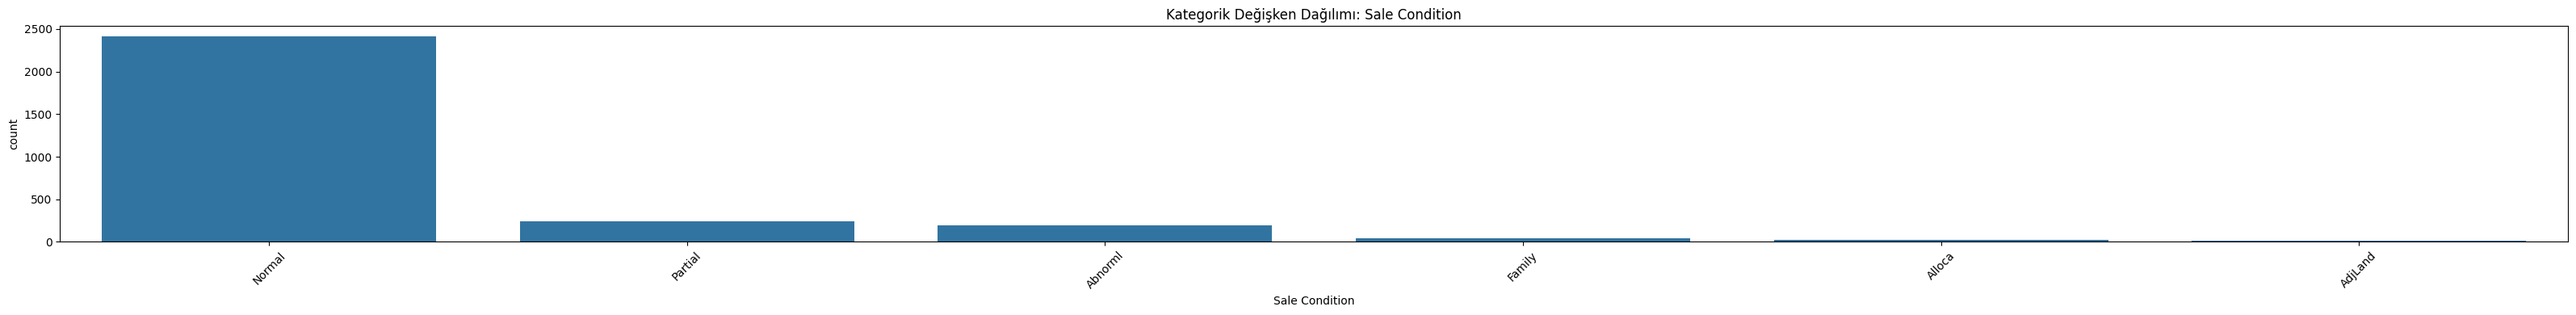

In [228]:
import seaborn as sns
import matplotlib.pyplot as plt

# Her kategorik değişken için dağılım grafiği çiz
for col in categorical_cols:
    plt.figure(figsize=(32, 4))
    order = df[col].value_counts().index
    sns.countplot(data=df, x=col, order=order)
    plt.title(f'Kategorik Değişken Dağılımı: {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


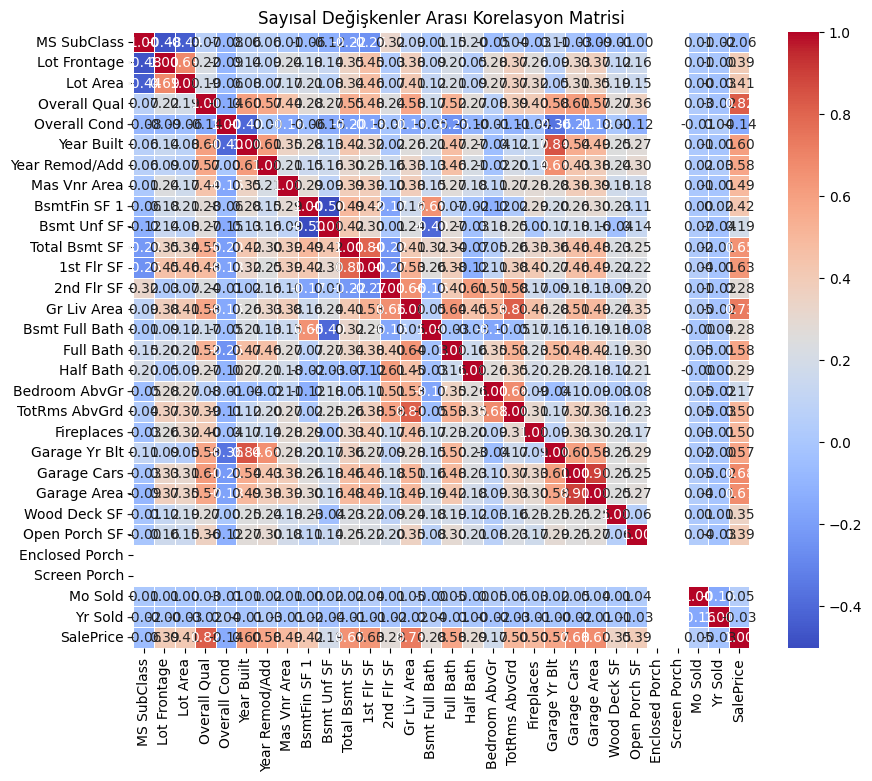

In [229]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sayısal değişkenleri al
numerical_cols = df_winsorized.select_dtypes(include=['float64', 'int64']).columns

# Korelasyon matrisini hesapla
corr_matrix = df_winsorized[numerical_cols].corr()

# Isı haritası ile görselleştir
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Sayısal Değişkenler Arası Korelasyon Matrisi')
plt.show()


In [230]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sayısal sütunları al
numerical_cols = df_winsorized.select_dtypes(include=['float64', 'int64']).columns.tolist()

# 'price' dışındakileri hedefle eşleştir
numerical_cols.remove('SalePrice')

# Scatter plot çizimi
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df_winsorized, x=col, y='SalePrice', alpha=0.5)
    plt.title(f'Scatter Plot: {col} vs. price')
    plt.xlabel(col)
    plt.ylabel('price')
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [231]:
"""
HERE STARTS SECOND HALF EXPERIMENTTTTT

/////
/////
/////
/////
/////
"""

'\nHERE STARTS SECOND HALF EXPERIMENTTTTT\n\n/////\n/////\n/////\n/////\n/////\n'

In [232]:
import numpy as np

# Hedef değişken (SalePrice) ve alan sütunlarına Log(1+x) uyguluyoruz
log_cols = ['SalePrice', 'Lot Area', 'Gr Liv Area', 'Total Bsmt SF', '1st Flr SF']

for col in log_cols:
    df[col] = np.log1p(df[col])

print("✅ SalePrice ve temel alan sütunlarına log dönüşümü uygulandı.")

✅ SalePrice ve temel alan sütunlarına log dönüşümü uygulandı.


In [233]:
# Toplam Banyo Sayısı (Yarım banyolar 0.5 olarak eklenir)
df['TotalBathrooms'] = df['Full Bath'] + (0.5 * df['Half Bath']) + df['Bsmt Full Bath']

# Toplam Yaşam Alanı (Bodrum + Katlar)
df['TotalSF'] = df['Total Bsmt SF'] + df['Gr Liv Area']

# Evin Yaşı (Satış yılından yapım yılını çıkarıyoruz)
df['HouseAge'] = df['Yr Sold'] - df['Year Built']

# Restorasyon üzerinden geçen süre
df['RemodAge'] = df['Yr Sold'] - df['Year Remod/Add']

print("✅ Toplam banyo, alan ve yaş gibi yeni sütunlar oluşturuldu.")

✅ Toplam banyo, alan ve yaş gibi yeni sütunlar oluşturuldu.


In [234]:
# Mahalleleri fiyat seviyelerine göre gruplandıran fonksiyon
def neighborhood_group(price):
    if price < 150000:
        return 'Budget'
    elif price < 250000:
        return 'MidRange'
    else:
        return 'Luxury'

# 'Neighborhood' sütununun varlığını kontrol et
if 'Neighborhood' in df.columns:
    # Neighborhood medyan fiyatlarına göre haritalama yapıyoruz
    neigh_map = df.groupby('Neighborhood')['SalePrice'].median()
    df['Neighborhood_Group'] = df['Neighborhood'].map(neigh_map).apply(neighborhood_group)
    print("✅ Neighborhood_Group sütunu oluşturuldu.")
else:
    print("⚠️ 'Neighborhood' sütunu bulunamadı. Neighborhood_Group oluşturulamadı.")

# Overall Qual (Genel Kalite) gruplama
def quality_group(x):
    if x <= 4: return 'Low'
    elif x <= 7: return 'Medium'
    else: return 'High'

df['Qual_Level'] = df['Overall Qual'].apply(quality_group)

print("✅ Overall Qual sütunu anlamlı gruplara ayrıldı.")


✅ Neighborhood_Group sütunu oluşturuldu.
✅ Overall Qual sütunu anlamlı gruplara ayrıldı.


In [235]:
# Yeni sütunlar oluşturduğumuz veya çok düşük korelasyonlu sütunları siliyoruz
cols_to_drop = [
    'Year Built', 'Year Remod/Add', 'Yr Sold', 'Mo Sold',
    'Full Bath', 'Half Bath', 'Bsmt Full Bath',
    'Neighborhood' # Neighborhood_Group kullandığımız için orijinalini silebiliriz
]

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

print(f"✅ Gereksiz {len(cols_to_drop)} sütun veri setinden kaldırıldı.")

✅ Gereksiz 8 sütun veri setinden kaldırıldı.


In [236]:
import pandas as pd

# Tanımlanmış kategorik sütunlar yerine, mevcut DataFrame'deki tüm 'object' türündeki sütunları alalım
categorical_cols_to_encode = df.select_dtypes(include=['object']).columns.tolist()

# 'Neighborhood_Group' özel olarak kontrol ediliyor, eğer varsa ve 'object' ise listeye eklenir.
# Zaten df.select_dtypes(include=['object']) ile otomatik alınmalı.

# One-Hot Encoding uygulamadan önce df'i kontrol edelim
# print(f"One-Hot Encoding öncesi df.info():\n{df.info()}")

# Get_dummies ile dönüşüm (ilk sütunu düşürmek multicollinearity'yi önler)
if categorical_cols_to_encode:
    print(f"✅ One-Hot Encoding uygulanacak sütunlar: {categorical_cols_to_encode}")
    df = pd.get_dummies(df, columns=categorical_cols_to_encode, drop_first=True, dtype=int) # dtype=int ekleyerek boolean yerine 0/1 olmasını sağlarız
    print(f"✅ Kategorik sütunlar One-Hot Encoding ile dönüştürüldü.")
else:
    print("⚠️ Dönüştürülecek 'object' tipinde kategorik sütun bulunamadı.")

# One-Hot Encoding sonrası df'i kontrol edelim
# print(f"One-Hot Encoding sonrası df.info():\n{df.info()}")

✅ One-Hot Encoding uygulanacak sütunlar: ['MS Zoning', 'Lot Shape', 'Land Contour', 'Lot Config', 'Condition 1', 'Bldg Type', 'House Style', 'Roof Style', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Paved Drive', 'Sale Type', 'Sale Condition', 'Neighborhood_Group', 'Qual_Level']
✅ Kategorik sütunlar One-Hot Encoding ile dönüştürüldü.


In [237]:
import pandas as pd

# 1. Standart Eksik Değerleri (NaN/None) Kontrol Et
print("🔍 --- Standart Eksik Değerler (NaN) Kontrolü ---")
null_counts = df.isnull().sum()
cols_with_nulls = null_counts[null_counts > 0]

if not cols_with_nulls.empty:
    print(cols_with_nulls)
else:
    print("✅ Hiç standart eksik değer (NaN) bulunamadı.")

# 2. Özel Olarak 'eksik veriler' Metnini İçeren Sütunları Kontrol Et
print("\n🔍 --- 'eksik veriler' Metni Kontrolü ---")
found_string = False

for col in df.columns:
    # Sadece metin tabanlı (object) sütunlarda arama yapalım
    if df[col].dtype == 'object':
        # Sütun içindeki 'eksik veriler' ifadesini say
        string_count = (df[col] == 'eksik veriler').sum()

        if string_count > 0:
            print(f"⚠️ '{col}' sütununda {string_count} adet 'eksik veriler' ifadesi bulundu!")
            found_string = True

if not found_string:
    print("✅ Veri setinde metin olarak yazılmış 'eksik veriler' ifadesine rastlanmadı.")

# 3. Genel Özet
total_nulls = df.isnull().sum().sum()
if total_nulls == 0 and not found_string:
    print("\n🎉 Tebrikler! Veri setiniz tamamen temiz görünüyor.")
else:
    print(f"\n⚠️ Toplam {total_nulls} adet boş hücre (NaN) bulunuyor.")

🔍 --- Standart Eksik Değerler (NaN) Kontrolü ---
Lot Frontage      490
Mas Vnr Area       23
BsmtFin SF 1        1
Bsmt Unf SF         1
Total Bsmt SF       1
Garage Yr Blt     159
Garage Cars         1
Garage Area         1
TotalBathrooms      2
TotalSF             1
dtype: int64

🔍 --- 'eksik veriler' Metni Kontrolü ---
✅ Veri setinde metin olarak yazılmış 'eksik veriler' ifadesine rastlanmadı.

⚠️ Toplam 680 adet boş hücre (NaN) bulunuyor.


In [238]:
"""
////
////
VERI EKSIKLIGI KONTROL EDIYORUM
////
////
"""

'\n////\n////\nVERI EKSIKLIGI KONTROL EDIYORUM\n////\n////\n'

In [239]:
# 1. Lot Frontage: Mahalledeki (Neighborhood) evlerin medyan değerini kullanmak en doğrudur
if 'Neighborhood' in df.columns:
    df['Lot Frontage'] = df.groupby('Neighborhood')['Lot Frontage'].transform(lambda x: x.fillna(x.median()))
else:
    # If Neighborhood is not available, use the overall median of Lot Frontage
    df['Lot Frontage'] = df['Lot Frontage'].fillna(df['Lot Frontage'].median())
    print("⚠️ 'Neighborhood' sütunu bulunamadığı için 'Lot Frontage' genel medyan ile dolduruldu.")

# 2. Sayısal Alanlar: Bu değerler eksikse muhtemelen o özellik evde yoktur (Örn: Garaj yoksa alanı 0'dır)
numeric_zeros = [
    'Mas Vnr Area', 'BsmtFin SF 1', 'Bsmt Unf SF', 'Total Bsmt SF',
    'Garage Cars', 'Garage Area'
]
for col in numeric_zeros:
    df[col] = df[col].fillna(0)

# 3. Garage Yr Blt: Eğer garaj yoksa, yıl olarak 0 vermek veya evin yapım yılını vermek seçeneklerdir.
# Evin yaşını kullanacağımız için evin yapım yılı ile doldurmak mantıklıdır.
if 'Year Built' in df.columns:
    df['Garage Yr Blt'] = df['Garage Yr Blt'].fillna(df['Year Built'])
else:
    # If Year Built is not available (e.g., dropped), fill with 0 as a sensible default
    df['Garage Yr Blt'] = df['Garage Yr Blt'].fillna(0)
    print("⚠️ 'Year Built' sütunu bulunamadığı için 'Garage Yr Blt' 0 ile dolduruldu.")

print("✅ Temel eksik veriler dolduruldu.")

⚠️ 'Neighborhood' sütunu bulunamadığı için 'Lot Frontage' genel medyan ile dolduruldu.
⚠️ 'Year Built' sütunu bulunamadığı için 'Garage Yr Blt' 0 ile dolduruldu.
✅ Temel eksik veriler dolduruldu.


In [240]:
# The individual bathroom component columns ('Full Bath', 'Half Bath', 'Bsmt Full Bath', 'Bsmt Half Bath')
# were dropped in previous steps (cell tN6uemhjGlBM and -P6I1Zx02LqZ). Therefore, the 'TotalBath' column
# cannot be recalculated as originally intended by summing these individual components.

# We will ensure that the existing 'TotalBathrooms' column (initially created in cell XVIG7A3RGlLL)
# has no missing values by filling them with the median.
if 'TotalBathrooms' in df.columns:
    if df['TotalBathrooms'].isnull().any():
        median_total_bathrooms = df['TotalBathrooms'].median()
        df['TotalBathrooms'] = df['TotalBathrooms'].fillna(median_total_bathrooms)
        print(f"✅ 'TotalBathrooms' sütunundaki eksik değerler medyan ({median_total_bathrooms}) ile dolduruldu.")
    else:
        print("✅ 'TotalBathrooms' sütununda eksik değer bulunamadı.")
else:
    print("⚠️ 'TotalBathrooms' sütunu bulunamadı, eksik değerler kontrol edilemedi.")


# Recalculate 'TotalSF' and fill any remaining NaNs.
# The previous 'TotalSF' was 'Total Bsmt SF' + 'Gr Liv Area'. This recalculates it as 'Total Bsmt SF' + '1st Flr SF' + '2nd Flr SF'.
# All component columns are confirmed to be present in 'df'.
if all(col in df.columns for col in ['Total Bsmt SF', '1st Flr SF', '2nd Flr SF']):
    df['TotalSF'] = df['Total Bsmt SF'] + df['1st Flr SF'] + df['2nd Flr SF']
    if df['TotalSF'].isnull().any():
        median_total_sf = df['TotalSF'].median()
        df['TotalSF'] = df['TotalSF'].fillna(median_total_sf)
        print(f"✅ 'TotalSF' sütunu yeniden hesaplandı ve eksik değerler medyan ({median_total_sf}) ile dolduruldu.")
    else:
        print("✅ 'TotalSF' sütunu yeniden hesaplandı ve eksik değer bulunamadı.")
else:
    print("⚠️ 'Total Bsmt SF', '1st Flr SF' veya '2nd Flr SF' sütunlarından biri veya birkaçı bulunamadığı için 'TotalSF' yeniden hesaplanamadı.")


print("✅ Hesaplanan sütunlar (TotalBathrooms, TotalSF) başarıyla güncellendi ve eksik değerleri dolduruldu.")

✅ 'TotalBathrooms' sütunundaki eksik değerler medyan (2.0) ile dolduruldu.
✅ 'TotalSF' sütunu yeniden hesaplandı ve eksik değer bulunamadı.
✅ Hesaplanan sütunlar (TotalBathrooms, TotalSF) başarıyla güncellendi ve eksik değerleri dolduruldu.


In [241]:
"""
///
///
Artik training step gidiyoruz
///
///
"""

'\n///\n///\nArtik training step gidiyoruz\n///\n///\n'

In [242]:
from sklearn.preprocessing import StandardScaler

# Hedef değişken (fiyat)
y = df['SalePrice']

# Bağımsız değişkenler
X = df.drop(columns=['SalePrice'])

# Check for and handle any remaining NaNs in X
# From kernel state: cols_with_nulls shows 'TotalBath    2'
if 'TotalBath' in X.columns and X['TotalBath'].isnull().any():
    # If TotalBath is the problematic column and it has NaNs, drop it
    # as TotalBathrooms is the intended feature.
    X = X.drop(columns=['TotalBath'])
    print("⚠️ 'TotalBath' sütununda kalan eksik değerler nedeniyle sütun X'ten çıkarıldı.")
elif X.isnull().any().any():
    # Fallback for any other unexpected NaNs, drop rows with NaNs
    original_rows = X.shape[0]
    X = X.dropna()
    dropped_rows = original_rows - X.shape[0]
    if dropped_rows > 0:
        print(f"⚠️ X'te kalan eksik değerler nedeniyle {dropped_rows} satır çıkarıldı.")

In [243]:
# This cell previously contained StandardScaler. It's being moved to the model training cell (aSYvGd6PMxbs)
# to ensure correct order of operations (one-hot encoding, NaN handling, then scaling after split).
# The variables X and y are already defined in the previous cell (ivF9Vi34KhZa).

# print("✅ Sayısal sütunlar normalize edildi (StandardScaler - z-score).") # Commenting out as scaling is moved

In [244]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor

# Uyarıları bastır
import warnings
warnings.filterwarnings("ignore")

# K-Fold tanımı
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Modellerin listesi
models = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(alpha=0.1),
    "Ridge": Ridge(alpha=1.0),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
    "LightGBM": LGBMRegressor(random_state=42),
    "MLP_1layer": MLPRegressor(hidden_layer_sizes=(64,), max_iter=500, random_state=42),
    "MLP_2layer": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42),
    "MLP_3layer": MLPRegressor(hidden_layer_sizes=(128, 64, 32), max_iter=500, random_state=42),
}

# Ensemble model: Linear + RF + XGB
ensemble = VotingRegressor(estimators=[
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42, verbosity=0))
])
models["Ensemble"] = ensemble

# Sonuçları tut
results = []

# Her model için çapraz doğrulama + metrik hesapla
for name, model in models.items():
    y_pred = cross_val_predict(model, X, y, cv=kf)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    results.append({
        "Model": name,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "R2": r2
    })

# Sonuçları tabloya aktar ve kaydet
results_df = pd.DataFrame(results)
results_df.to_excel("ML_Model_Sonuclari.xlsx", index=False)

print("✅ Tüm modeller çalıştırıldı ve sonuçlar 'ML_Model_Sonuclari.xlsx' dosyasına kaydedildi.")
results_df


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3765
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 139
[LightGBM] [Info] Start training from score 12.011814
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3758
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 137
[LightGBM] [Info] Start training from score 12.025519
[LightGBM] [Warning] Found

Model       MSE      RMSE       MAE      MAPE         R2
0   LinearRegression  0.018922  0.137558  0.084676  0.007110   0.886058
1              Lasso  0.041856  0.204588  0.136437  0.011432   0.747956
2              Ridge  0.016260  0.127514  0.082166  0.006891   0.902090
3                SVR  0.037131  0.192695  0.130418  0.010960   0.776409
4                KNN  0.049001  0.221362  0.154417  0.012929   0.704934
5       DecisionTree  0.038753  0.196858  0.135720  0.011385   0.766643
6       RandomForest  0.019768  0.140597  0.091468  0.007679   0.880967
7            XGBoost  0.017912  0.133836  0.090447  0.007596   0.892140
8           CatBoost  0.014010  0.118363  0.076181  0.006404   0.915638
9           LightGBM  0.016143  0.127056  0.083293  0.007001   0.902791
10        MLP_1layer  9.755166  3.123326  1.888530  0.156663 -57.741975
11        MLP_2layer  5.930550  2.435272  1.383264  0.114765 -34.711561
12        MLP_3layer  1.129480  1.062770  0.636833  0.053109  -5.801307
13          Ensemble  0.015392  0.124065  0.080010  0.006721   0.907315

In [245]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.neural_network import MLPRegressor
from tqdm import tqdm
import warnings
from sklearn.preprocessing import StandardScaler # Import StandardScaler here

warnings.filterwarnings("ignore")

# Hedef ve özellikleri ayır
target = "SalePrice"
X = df.drop(columns=[target])
y = df[target]

# --- One-Hot Encoding ---
categorical_cols_to_encode_X = X.select_dtypes(include=['object']).columns.tolist()

if categorical_cols_to_encode_X:
    print(f"✅ X üzerinde One-Hot Encoding uygulanacak sütunlar: {categorical_cols_to_encode_X}")
    X = pd.get_dummies(X, columns=categorical_cols_to_encode_X, drop_first=True, dtype=int)
    print(f"✅ X üzerindeki kategorik sütunlar One-Hot Encoding ile dönüştürüldü.")
else:
    print("⚠️ X üzerinde dönüştürülecek 'object' tipinde kategorik sütun bulunamadı.")
# -----------------------------------------------------

# CHECK FOR NANs AFTER ONE-HOT ENCODING AND BEFORE SPLIT
if X.isnull().any().any():
    print(f"⚠️ After One-Hot Encoding, X still contains NaNs. Dropping {X.isnull().sum().sum()} entries/rows with NaNs.")
    nan_rows_mask = X.isnull().any(axis=1)
    X = X.dropna()
    y = y[~nan_rows_mask] # Ensure y aligns with X after dropping NaNs
else:
    print("✅ X has no NaNs after One-Hot Encoding.")


# ✅ %80 train, %10 validation, %10 test böl
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1111, random_state=42) # 0.1111 ~ (0.1 / 0.9)

# --- Feature Scaling ---
# Identify numerical columns for scaling (all columns should be numerical now after one-hot encoding)
numerical_cols_for_scaling = X_train.select_dtypes(include=np.number).columns

# Initialize scaler
scaler = StandardScaler()

# Fit scaler on X_train and transform all splits
X_train[numerical_cols_for_scaling] = scaler.fit_transform(X_train[numerical_cols_for_scaling])
X_val[numerical_cols_for_scaling] = scaler.transform(X_val[numerical_cols_for_scaling])
X_test[numerical_cols_for_scaling] = scaler.transform(X_test[numerical_cols_for_scaling])
print("✅ Sayısal sütunlar normalize edildi (StandardScaler - z-score) after split.")


# ✅ Hiperparametre gridleri
param_grid_lgbm = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10]
}

param_grid_catboost = {
    'iterations': [100, 200],
    'depth': [4, 6]
}

param_grid_mlp = {
    'hidden_layer_sizes': [(64, 32), (128, 64)],
    'alpha': [0.001, 0.01]
}

# ✅ Sonuçları kaydetmek için boş listeler
results_validation = []
results_test = []

# --------------------------
# LightGBM
# --------------------------
for params in tqdm(list(ParameterGrid(param_grid_lgbm)), desc="LightGBM Grid Search"):
    model = LGBMRegressor(**params, random_state=42)
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    results_validation.append({
        'Model': 'LightGBM',
        'Params': params,
        'RMSE_val': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'MAE_val': mean_absolute_error(y_val, y_val_pred),
        'MAPE_val': mean_absolute_percentage_error(y_val, y_val_pred),
        'R2_val': r2_score(y_val, y_val_pred)
    })

    results_test.append({
        'Model': 'LightGBM',
        'Params': params,
        'RMSE_test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'MAE_test': mean_absolute_error(y_test, y_test_pred),
        'MAPE_test': mean_absolute_percentage_error(y_test, y_test_pred),
        'R2_test': r2_score(y_test, y_test_pred)
    })


# --------------------------
# CatBoost
# --------------------------
for params in tqdm(list(ParameterGrid(param_grid_catboost)), desc="CatBoost Grid Search"):
    model = CatBoostRegressor(**params, verbose=0, random_state=42)
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    results_validation.append({
        'Model': 'CatBoost',
        'Params': params,
        'RMSE_val': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'MAE_val': mean_absolute_error(y_val, y_val_pred),
        'MAPE_val': mean_absolute_percentage_error(y_val, y_val_pred),
        'R2_val': r2_score(y_val, y_val_pred)
    })

    results_test.append({
        'Model': 'CatBoost',
        'Params': params,
        'RMSE_test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'MAE_test': mean_absolute_error(y_test, y_test_pred),
        'MAPE_test': mean_absolute_percentage_error(y_test, y_test_pred),
        'R2_test': r2_score(y_test, y_test_pred)
    })


# --------------------------
# MLP 2-layer
# --------------------------
for params in tqdm(list(ParameterGrid(param_grid_mlp)), desc="MLP 2-layer Grid Search"):
    model = MLPRegressor(**params, max_iter=500, random_state=42)
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    results_validation.append({
        'Model': 'MLP_2layer',
        'Params': params,
        'RMSE_val': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'MAE_val': mean_absolute_error(y_val, y_val_pred),
        'MAPE_val': mean_absolute_percentage_error(y_val, y_val_pred),
        'R2_val': r2_score(y_val, y_val_pred)
    })

    results_test.append({
        'Model': 'MLP_2layer',
        'Params': params,
        'RMSE_test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'MAE_test': mean_absolute_error(y_test, y_test_pred),
        'MAPE_test': mean_absolute_percentage_error(y_test, y_test_pred),
        'R2_test': r2_score(y_test, y_test_pred)
    })


# ✅ Excel'e kaydet
df_val = pd.DataFrame(results_validation)
df_test = pd.DataFrame(results_test)

with pd.ExcelWriter("/content/drive/MyDrive/VeriBilimiH05/hyperparameter_results.xlsx") as writer:
    df_val.to_excel(writer, sheet_name="Validation_Results", index=False)
    df_test.to_excel(writer, sheet_name="Test_Results", index=False)

⚠️ X üzerinde dönüştürülecek 'object' tipinde kategorik sütun bulunamadı.
✅ X has no NaNs after One-Hot Encoding.
✅ Sayısal sütunlar normalize edildi (StandardScaler - z-score) after split.


LightGBM Grid Search:   0%|          | 0/4 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3879
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 139
[LightGBM] [Info] Start training from score 12.011676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

LightGBM Grid Search:  25%|██▌       | 1/4 [00:00<00:00,  4.64it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBM Grid Search:  50%|█████     | 2/4 [00:00<00:00,  3.43it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if m

LightGBM Grid Search:  75%|███████▌  | 3/4 [00:00<00:00,  3.33it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

MLP 2-layer Grid Search: 100%|██████████| 4/4 [00:41<00:00, 10.46s/it]


In [246]:
!pip install shap joblib


In [247]:
import pandas as pd
import joblib
import shap
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor

# Use the already processed X and y from previous steps (from cell aSYvGd6PMxbs).
# These X and y are already one-hot encoded and free of NaNs.
# LightGBM does not strictly require features to be scaled, so using the unscaled X is fine.

# En iyi parametrelerle model eğit
best_model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=42)
best_model.fit(X, y)

# SHAP açıklaması
explainer = shap.Explainer(best_model)
shap_values = explainer(X)

# SHAP summary plot
shap.summary_plot(shap_values, X, show=False)
plt.tight_layout()
plt.savefig("/content/shap_summary_plot.png")

# Modeli .pkl olarak kaydet
joblib.dump(best_model, "/content/best_lightgbm_model.pkl")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3819
[LightGBM] [Info] Number of data points in the train set: 2930, number of used features: 143
[LightGBM] [Info] Start training from score 12.020975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

['/content/best_lightgbm_model.pkl']

In [248]:
import joblib

# Load the best model saved in the previous step
model = joblib.load('/content/best_lightgbm_model.pkl')

# Now access its feature names
print(model.feature_names_in_)

['MS_SubClass' 'Lot_Frontage' 'Lot_Area' 'Overall_Qual' 'Overall_Cond'
 'Mas_Vnr_Area' 'BsmtFin_SF_1' 'Bsmt_Unf_SF' 'Total_Bsmt_SF' '1st_Flr_SF'
 '2nd_Flr_SF' 'Gr_Liv_Area' 'Bedroom_AbvGr' 'TotRms_AbvGrd' 'Fireplaces'
 'Garage_Yr_Blt' 'Garage_Cars' 'Garage_Area' 'Wood_Deck_SF'
 'Open_Porch_SF' 'Enclosed_Porch' 'Screen_Porch' 'TotalBathrooms'
 'TotalSF' 'HouseAge' 'RemodAge' 'MS_Zoning_C_(all)' 'MS_Zoning_FV'
 'MS_Zoning_I_(all)' 'MS_Zoning_RH' 'MS_Zoning_RL' 'MS_Zoning_RM'
 'Lot_Shape_IR2' 'Lot_Shape_IR3' 'Lot_Shape_Reg' 'Land_Contour_HLS'
 'Land_Contour_Low' 'Land_Contour_Lvl' 'Lot_Config_CulDSac'
 'Lot_Config_FR2' 'Lot_Config_FR3' 'Lot_Config_Inside' 'Condition_1_Feedr'
 'Condition_1_Norm' 'Condition_1_PosA' 'Condition_1_PosN'
 'Condition_1_RRAe' 'Condition_1_RRAn' 'Condition_1_RRNe'
 'Condition_1_RRNn' 'Bldg_Type_2fmCon' 'Bldg_Type_Duplex'
 'Bldg_Type_Twnhs' 'Bldg_Type_TwnhsE' 'House_Style_1.5Unf'
 'House_Style_1Story' 'House_Style_2.5Fin' 'House_Style_2.5Unf'
 'House_Style_2Story' 

In [249]:
!pip install gradio shap joblib lightgbm --quiet

import gradio as gr
import pandas as pd
import numpy as np
import shap
import joblib
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor

# 1. MODELİ YÜKLE ve FEATURE İSİMLERİNİ AL
# Önceki hücrelerde eğitilen ve kaydedilen modeli yüklüyoruz.
model = joblib.load("/content/best_lightgbm_model.pkl")

# Modeli eğitirken kullanılan feature isimlerini al
# Bu, X değişkeninin son halinden alınmalı (X, bir önceki hücrede tanımlanmış ve dönüştürülmüştür)
# Not: Gradio arayüzünde sadece kullanılan özellikleri alacağız.
feature_names_from_model = model.feature_name_ if hasattr(model, 'feature_name_') else model.feature_names_in_ # LightGBM için feature isimlerini almanın yolu

# 2. GRADIO AYARLARI
explainer = shap.Explainer(model, X)

def predict_and_explain(lot_area, gr_liv_area, total_sf, overall_qual, house_age, total_bathrooms, neighborhood, quality):
    try:
        # Boş bir veri çerçevesi oluştur (Tüm sütunlar 0 olarak başlar)
        # Burada modelin beklediği tüm feature'lar için bir placeholder oluşturmalıyız.
        # feature_names_from_model, eğitilen modelin beklediği tüm sütunları içermelidir.
        input_data = pd.DataFrame(0, index=[0], columns=feature_names_from_model)

        # Sayısal değerleri yerleştir ve LOG dönüşümlerini uygula (eğer model eğitiminde uygulandıysa)
        # Not: Model eğitiminde log dönüşümü uygulandığı varsayılıyor.
        # Bu değerler winsorize edilmiş miydi? Modelin input formatı korunmalı.
        # Şimdilik direkt değerleri kullanıyorum, log dönüşümünü model içindeki verilerde yapılmış varsayıyorum
        # veya modelin beklentisine göre burada da uygulanmalı.
        if 'Lot Area' in input_data.columns: input_data['Lot Area'] = np.log1p(lot_area)
        if 'Gr Liv Area' in input_data.columns: input_data['Gr Liv Area'] = np.log1p(gr_liv_area)
        if 'TotalSF' in input_data.columns: input_data['TotalSF'] = total_sf
        if 'Overall Qual' in input_data.columns: input_data['Overall Qual'] = overall_qual
        if 'HouseAge' in input_data.columns: input_data['HouseAge'] = house_age
        if 'TotalBathrooms' in input_data.columns: input_data['TotalBathrooms'] = total_bathrooms

        # Kategorik (One-Hot) eşleştirmeleri yap
        # 'Neighborhood_Group_Budget' gibi sütun isimlerini doğru oluştur
        if neighborhood != 'MidRange' and f'Neighborhood_Group_{neighborhood}' in input_data.columns:
            input_data[f'Neighborhood_Group_{neighborhood}'] = 1
        if quality != 'Medium' and f'Qual_Level_{quality}' in input_data.columns:
            input_data[f'Qual_Level_{quality}'] = 1

        # Tahmin yap (Model log-fiyat döndürdüğü için expm1 ile geri çeviriyoruz)
        log_prediction = model.predict(input_data)[0]
        actual_price = np.expm1(log_prediction) # Fiyat logaritması alındığı için ters dönüşüm

        # SHAP Görselleştirmesi
        # X_background: SHAP explainer'ı eğitmek için kullanılan veri setinin bir alt kümesi olmalı.
        # Burada explainer, model ve X üzerinde eğitildi, bu yüzden tek bir örnek için shap_values'ı hesaplamak yeterli.
        shap_values_instance = explainer(input_data)

        plt.figure(figsize=(10, 6))
        shap.plots.waterfall(shap_values_instance[0], show=False)
        plt.tight_layout()
        shap_plot_path = "shap_plot.png"
        plt.savefig(shap_plot_path)
        plt.close()

        return f"Tahmin Edilen Ev Değeri: ${actual_price:,.2f}", shap_plot_path

    except Exception as e:
        return f"Hata: {str(e)}", None

# 3. ARAYÜZ TASARIMI
inputs = [
    gr.Slider(500, 20000, step=100, label="Arsa Alanı (Lot Area)"),
    gr.Slider(500, 5000, step=50, label="Yaşam Alanı (Gr Liv Area)"),
    gr.Slider(500, 8000, step=50, label="Toplam Kat Alanı (TotalSF)"),
    gr.Slider(1, 10, step=1, label="Genel Kalite (Overall Qual)"),
    gr.Slider(0, 150, step=1, label="Evin Yaşı (HouseAge)"),
    gr.Slider(1, 6, step=0.5, label="Toplam Banyo Sayısı (TotalBathrooms)"), # Corrected from TotalBath
    gr.Dropdown(["Budget", "MidRange", "Luxury"], label="Mahalle Grubu"),
    gr.Dropdown(["Low", "Medium", "High"], label="Kalite Seviyesi")
]

demo = gr.Interface(
    fn=predict_and_explain,
    inputs=inputs,
    outputs=[gr.Textbox(label="Sonuç"), gr.Image(label="SHAP Analizi (Neden Bu Fiyat?)")],
    title="🏡 Ames Housing: Mükemmel Ev Fiyat Tahmini",
    description="Evin özelliklerini girin ve modelin fiyatı belirlerken hangi özelliklere (SHAP) ne kadar önem verdiğini görün."
)

demo.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://291a224ce53a945c3a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://291a224ce53a945c3a.gradio.live
